# All imports

In [ ]:
import cv2
import os
import random
from google.colab import drive
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D, Concatenate, Input, Add
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import seaborn as sns
import time
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# Drive Set up

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
input_dirs = {
    'rotten': '/content/drive/MyDrive/data/rotten',
    'mid': '/content/drive/MyDrive/data/mid',
    'fresh': '/content/drive/MyDrive/data/fresh'
}

In [ ]:
output_dirs = {
    'rotten': '/content/drive/MyDrive/data/rotten_frames',
    'mid': '/content/drive/MyDrive/data/mid_frames',
    'fresh': '/content/drive/MyDrive/data/fresh_frames'
}

In [ ]:
for category, out_dir in output_dirs.items():
    os.makedirs(out_dir, exist_ok=True)

# Dataset Preparation

## Frame Extraction

In [ ]:
# Function to extract frames
def extract_frames(video_path, output_folder, category, num_frames=5):
    video_name = os.path.splitext(os.path.basename(video_path))[0]
    cap = cv2.VideoCapture(video_path)

    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    if total_frames < num_frames:
        print(f"Video {video_name} has fewer than {num_frames} frames.")
        num_frames = total_frames

    # Evenly spaced frame indices
    frame_indices = np.linspace(0, total_frames - 1, num_frames, dtype=int)

    current_index = 0
    saved_count = 0
    frame_id = 0

    while cap.isOpened() and saved_count < num_frames:
        success, frame = cap.read()
        if not success:
            break
        if frame_id == frame_indices[saved_count]:
            frame_filename = f"{category}_{video_name}_frame_{saved_count}.jpg"
            cv2.imwrite(os.path.join(output_folder, frame_filename), frame)
            saved_count += 1
        frame_id += 1

    cap.release()

In [ ]:
# Extract frames for each category
for category, input_folder in input_dirs.items():
    for video_file in os.listdir(input_folder):
        video_path = os.path.join(input_folder, video_file)
        if video_file.lower().endswith('.mp4'):
            print(f"Extracting frames from {video_file} in {category}")
            extract_frames(video_path, output_dirs[category], category)

print("All frames extracted for fresh, mid, and rotten categories.")

Extracting frames from rotten_009.mp4 in rotten
Extracting frames from rotten_008.mp4 in rotten
Extracting frames from rotten_007.mp4 in rotten
Extracting frames from rotten_006.mp4 in rotten
Extracting frames from rotten_005.mp4 in rotten
Extracting frames from rotten_004.mp4 in rotten
Extracting frames from rotten_003.mp4 in rotten
Extracting frames from rotten_002.mp4 in rotten
Extracting frames from rotten_001.mp4 in rotten
Extracting frames from rotten_010.mp4 in rotten
Extracting frames from rotten_011.mp4 in rotten
Extracting frames from rotten_012.mp4 in rotten
Extracting frames from mid_001.mp4 in mid
Extracting frames from mid_006.mp4 in mid
Extracting frames from mid_008.mp4 in mid
Extracting frames from mid_005.mp4 in mid
Extracting frames from mid_007.mp4 in mid
Extracting frames from mid_004.mp4 in mid
Extracting frames from mid_002.mp4 in mid
Extracting frames from mid_003.mp4 in mid
Extracting frames from mid_010.mp4 in mid
Extracting frames from mid_012.mp4 in mid
Extr

In [ ]:
fresh_frames_dir = '/content/drive/MyDrive/data/fresh_frames'
mid_frames_dir = '/content/drive/MyDrive/data/mid_frames'
rotten_frames_dir = '/content/drive/MyDrive/data/rotten_frames'

fresh_images_count = len([file for file in os.listdir(fresh_frames_dir) if file.endswith('.jpg')])
mid_images_count = len([file for file in os.listdir(mid_frames_dir) if file.endswith('.jpg')])
rotten_images_count = len([file for file in os.listdir(rotten_frames_dir) if file.endswith('.jpg')])

print(f"Number of images in fresh_frames: {fresh_images_count}")
print(f"Number of images in mid_frames: {mid_images_count}")
print(f"Number of images in rotten_frames: {rotten_images_count}")

Number of images in fresh_frames: 110
Number of images in mid_frames: 130
Number of images in rotten_frames: 60


## Frame Augmentation

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, save_img

def augment_images(input_dir, output_dir, n_augmented=10):
    #Augmentations
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        brightness_range=[1.2, 1.2]
    )

    #Output dir to save aug images
    os.makedirs(output_dir, exist_ok=True)
    print(f"Saving augmented images to: {output_dir}")

    for img_name in os.listdir(input_dir):
        img_path = os.path.join(input_dir, img_name)
        try:
            img = load_img(img_path)
            x = img_to_array(img)
            x = x.reshape((1,) + x.shape)

            i = 0
            for batch in datagen.flow(x, batch_size=1):
                aug_img_name = f"aug_{i}_{img_name}"
                aug_img_path = os.path.join(output_dir, aug_img_name)
                save_img(aug_img_path, batch[0])
                i += 1
                if i >= n_augmented:
                    break
        except Exception as e:
            print(f"Error processing {img_name}: {e}")


#Augmented images folder
base_path = "/content/drive/MyDrive/data"
os.makedirs(os.path.join(base_path, "augmented"), exist_ok=True)

augment_images(os.path.join(base_path, "fresh_frames"), os.path.join(base_path, "augmented", "augmented_fresh_frames"))
augment_images(os.path.join(base_path, "mid_frames"), os.path.join(base_path, "augmented", "augmented_mid_frames"))
augment_images(os.path.join(base_path, "rotten_frames"), os.path.join(base_path, "augmented", "augmented_rotten_frames"))

Saving augmented images to: /content/drive/MyDrive/data/augmented/augmented_fresh_frames
Saving augmented images to: /content/drive/MyDrive/data/augmented/augmented_mid_frames
Saving augmented images to: /content/drive/MyDrive/data/augmented/augmented_rotten_frames


## Data preprocessing

In [ ]:
base_path = "/content/drive/MyDrive/data/augmented"

folders = {
    "fresh": "augmented_fresh_frames",
    "mid": "augmented_mid_frames",
    "rotten": "augmented_rotten_frames"
}

for label, folder in folders.items():
    folder_path = os.path.join(base_path, folder)
    count = len([f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))])
    print(f"Number of images in {folder}: {count}")

Number of images in augmented_fresh_frames: 1100
Number of images in augmented_mid_frames: 1300
Number of images in augmented_rotten_frames: 600


In [ ]:
rotten_dir = os.path.join(base_path, 'augmented_rotten_frames')
mid_dir = os.path.join(base_path, 'augmented_mid_frames')
fresh_dir = os.path.join(base_path, 'augmented_fresh_frames')

In [ ]:
batch_size = 32
img_size = (224, 224)

datagen = ImageDataGenerator(
    validation_split=0.3,
)
#Training data
train_data = datagen.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)
#Validation data
val_data = datagen.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2100 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


# Models Training

## VGG16

In [ ]:
#RGB to BGR
from tensorflow.keras.applications.vgg16 import preprocess_input

datagen_vgg = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.3
)

#Loading training data
train_data_vgg = datagen_vgg.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

#Loading validation data
val_data_vgg = datagen_vgg.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2100 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import VGG16

#Loading vgg16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the base layers
for layer in base_model.layers:
    layer.trainable = False

#Model Building
model_vgg = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
#Compilation
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Model summary
model_vgg.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,787 (56.64 MB)

 Trainable params: 132,099 (516.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Save the best model based on validation accuracy at a particular epoch
checkpoint_vgg = ModelCheckpoint(
    "best_vgg_model.h5",
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

start_vgg = time.time()  # Timer start

history_vgg = model_vgg.fit(
    train_data_vgg,
    epochs=50,
    validation_data=val_data_vgg,
    callbacks=[checkpoint_vgg]
)

end_vgg = time.time()  # Timer stop
runtime_vgg = end_vgg - start_vgg

print(f"Training Time for VGG16 model: {runtime_vgg:.2f} seconds")

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step - accuracy: 0.3811 - loss: 3.4896
Epoch 1: val_accuracy improved from -inf to 0.83444, saving model to best_vgg_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 53s 593ms/step - accuracy: 0.3834 - loss: 3.4733 - val_accuracy: 0.8344 - val_loss: 0.6327
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.7652 - loss: 1.0370
Epoch 2: val_accuracy improved from 0.83444 to 0.89222, saving model to best_vgg_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 397ms/step - accuracy: 0.7654 - loss: 1.0365 - val_accuracy: 0.8922 - val_loss: 0.4248
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.8104 - loss: 0.7655
Epoch 3: val_accuracy improved from 0.89222 to 0.90222, saving model to best_vgg_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 395ms/step - accuracy: 0.8108 - loss: 0.7637 - val_accuracy: 0.9022 - val_loss: 0.2820
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.8353 - loss: 0.5901
Epoch 4: val_accuracy improved from 0.90222 to 0.91444, saving model to best_vgg_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 398ms/step - accuracy: 0.8355 - loss: 0.5897 - val_accuracy: 0.9144 - val_loss: 0.2478
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.8682 - loss: 0.4372
Epoch 5: val_accuracy improved from 0.91444 to 0.92222, saving model to best_vgg_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 391ms/step - accuracy: 0.8682 - loss: 0.4372 - val_accuracy: 0.9222 - val_loss: 0.2000
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.8804 - loss: 0.3825
Epoch 6: val_accuracy improved from 0.92222 to 0.92889, saving model to best_vgg_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 400ms/step - accuracy: 0.8805 - loss: 0.3822 - val_accuracy: 0.9289 - val_loss: 0.1798
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.8998 - loss: 0.3115
Epoch 7: val_accuracy did not improve from 0.92889
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 397ms/step - accuracy: 0.8998 - loss: 0.3115 - val_accuracy: 0.9278 - val_loss: 0.1654
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9042 - loss: 0.2682
Epoch 8: val_accuracy improved from 0.92889 to 0.93111, saving model to best_vgg_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 408ms/step - accuracy: 0.9043 - loss: 0.2680 - val_accuracy: 0.9311 - val_loss: 0.1577
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9144 - loss: 0.2328
Epoch 9: val_accuracy improved from 0.93111 to 0.94667, saving model to best_vgg_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 393ms/step - accuracy: 0.9144 - loss: 0.2327 - val_accuracy: 0.9467 - val_loss: 0.1340
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step - accuracy: 0.9166 - loss: 0.2271
Epoch 10: val_accuracy improved from 0.94667 to 0.94889, saving model to best_vgg_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 401ms/step - accuracy: 0.9167 - loss: 0.2272 - val_accuracy: 0.9489 - val_loss: 0.1268
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9248 - loss: 0.1968
Epoch 11: val_accuracy improved from 0.94889 to 0.95111, saving model to best_vgg_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 435ms/step - accuracy: 0.9247 - loss: 0.1971 - val_accuracy: 0.9511 - val_loss: 0.1193
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step - accuracy: 0.9163 - loss: 0.2026
Epoch 12: val_accuracy improved from 0.95111 to 0.95222, saving model to best_vgg_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 396ms/step - accuracy: 0.9165 - loss: 0.2023 - val_accuracy: 0.9522 - val_loss: 0.1167
Epoch 13/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9466 - loss: 0.1442
Epoch 13: val_accuracy did not improve from 0.95222
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 396ms/step - accuracy: 0.9465 - loss: 0.1444 - val_accuracy: 0.9522 - val_loss: 0.1121
Epoch 14/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9363 - loss: 0.1533
Epoch 14: val_accuracy improved from 0.95222 to 0.95667, saving model to best_vgg_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 395ms/step - accuracy: 0.9363 - loss: 0.1535 - val_accuracy: 0.9567 - val_loss: 0.1076
Epoch 15/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9428 - loss: 0.1422
Epoch 15: val_accuracy did not improve from 0.95667
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 408ms/step - accuracy: 0.9428 - loss: 0.1423 - val_accuracy: 0.9544 - val_loss: 0.1067
Epoch 16/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9465 - loss: 0.1299
Epoch 16: val_accuracy did not improve from 0.95667
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 410ms/step - accuracy: 0.9466 - loss: 0.1299 - val_accuracy: 0.9544 - val_loss: 0.1029
Epoch 17/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step - accuracy: 0.9507 - loss: 0.1171
Epoch 17: val_accuracy did not improve from 0.95667
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 399ms/step - accuracy: 0.9507 - loss: 0.1172 - val_accuracy: 0.9567 - val_loss: 0.1063
Epoch 18/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9545 - loss: 0.1196
Epoch 18: val_accuracy d

66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 410ms/step - accuracy: 0.9618 - loss: 0.0941 - val_accuracy: 0.9611 - val_loss: 0.0982
Epoch 20/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9523 - loss: 0.1267
Epoch 20: val_accuracy did not improve from 0.96111
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 401ms/step - accuracy: 0.9523 - loss: 0.1267 - val_accuracy: 0.9600 - val_loss: 0.0977
Epoch 21/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step - accuracy: 0.9594 - loss: 0.1161
Epoch 21: val_accuracy did not improve from 0.96111
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 381ms/step - accuracy: 0.9594 - loss: 0.1161 - val_accuracy: 0.9589 - val_loss: 0.0966
Epoch 22/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.9584 - loss: 0.1072
Epoch 22: val_accuracy did not improve from 0.96111
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 392ms/step - accuracy: 0.9585 - loss: 0.1071 - val_accuracy: 0.9611 - val_loss: 0.0966
Epoch 23/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9428 - loss: 0.1131
Epoch 23: val_accuracy d

66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 423ms/step - accuracy: 0.9567 - loss: 0.0981 - val_accuracy: 0.9622 - val_loss: 0.0903
Epoch 26/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9621 - loss: 0.0991
Epoch 26: val_accuracy improved from 0.96222 to 0.96333, saving model to best_vgg_model.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 396ms/step - accuracy: 0.9621 - loss: 0.0990 - val_accuracy: 0.9633 - val_loss: 0.0897
Epoch 27/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9558 - loss: 0.0816
Epoch 27: val_accuracy did not improve from 0.96333
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 401ms/step - accuracy: 0.9558 - loss: 0.0816 - val_accuracy: 0.9600 - val_loss: 0.0906
Epoch 28/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9685 - loss: 0.0729
Epoch 28: val_accuracy did not improve from 0.96333
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 392ms/step - accuracy: 0.9685 - loss: 0.0730 - val_accuracy: 0.9611 - val_loss: 0.0906
Epoch 29/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9616 - loss: 0.0845
Epoch 29: val_accuracy did not improve from 0.96333
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 383ms/step - accuracy: 0.9617 - loss: 0.0845 - val_accuracy: 0.9589 - val_loss: 0.0886
Epoch 30/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.9669 - loss: 0.0837
Epoch 30: val_accuracy i

66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 426ms/step - accuracy: 0.9668 - loss: 0.0837 - val_accuracy: 0.9678 - val_loss: 0.0905
Epoch 31/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9749 - loss: 0.0698
Epoch 31: val_accuracy did not improve from 0.96778
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 400ms/step - accuracy: 0.9748 - loss: 0.0698 - val_accuracy: 0.9622 - val_loss: 0.0894
Epoch 32/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9668 - loss: 0.0716
Epoch 32: val_accuracy did not improve from 0.96778
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 398ms/step - accuracy: 0.9668 - loss: 0.0716 - val_accuracy: 0.9622 - val_loss: 0.0903
Epoch 33/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9719 - loss: 0.0722
Epoch 33: val_accuracy did not improve from 0.96778
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 377ms/step - accuracy: 0.9719 - loss: 0.0723 - val_accuracy: 0.9567 - val_loss: 0.0913
Epoch 34/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9753 - loss: 0.0698
Epoch 34: val_accuracy d

In [ ]:
model_vgg = load_model("best_vgg_model.h5")

In [ ]:
loss_vgg, accuracy_vgg = model_vgg.evaluate(val_data_vgg)
print(f"Validation Accuracy: {accuracy_vgg:.4f}, Validation Loss: {loss_vgg:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 267ms/step - accuracy: 0.9619 - loss: 0.0985
Validation Accuracy: 0.9678, Validation Loss: 0.0905


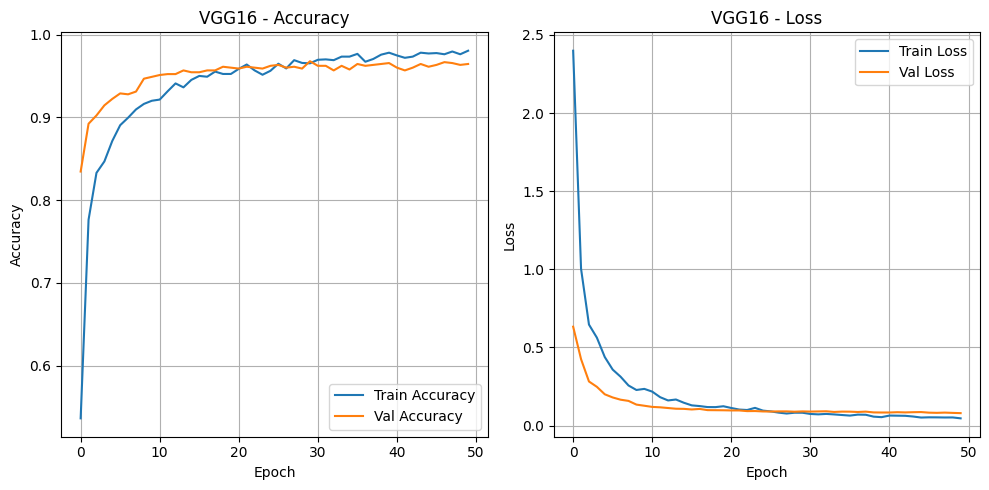

In [ ]:
#Plots for VGG16 Accuracy and loss
plt.figure(figsize=(10, 5))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_vgg.history['accuracy'], label='Train Accuracy')
plt.plot(history_vgg.history['val_accuracy'], label='Val Accuracy')
plt.title('VGG16 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

#Loss
plt.subplot(1, 2, 2)
plt.plot(history_vgg.history['loss'], label='Train Loss')
plt.plot(history_vgg.history['val_loss'], label='Val Loss')
plt.title('VGG16 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Cnfusion matrix
#Prediction on validation data
val_pred_vgg = model_vgg.predict(val_data_vgg)
y_pred_vgg = np.argmax(val_pred_vgg, axis=1)

y_true_vgg = val_data_vgg.classes

class_names = list(val_data_vgg.class_indices.keys())

29/29 ━━━━━━━━━━━━━━━━━━━━ 405s 14s/step


In [ ]:
from sklearn.metrics import classification_report
# Classification report
report = classification_report(y_true_vgg, y_pred_vgg, target_names=class_names)
print("Classification Report - VGG16")
print(report)

Classification Report - VGG16
                         precision    recall  f1-score   support

 augmented_fresh_frames       0.97      0.95      0.96       330
   augmented_mid_frames       0.95      0.98      0.96       390
augmented_rotten_frames       1.00      0.98      0.99       180

               accuracy                           0.97       900
              macro avg       0.97      0.97      0.97       900
           weighted avg       0.97      0.97      0.97       900



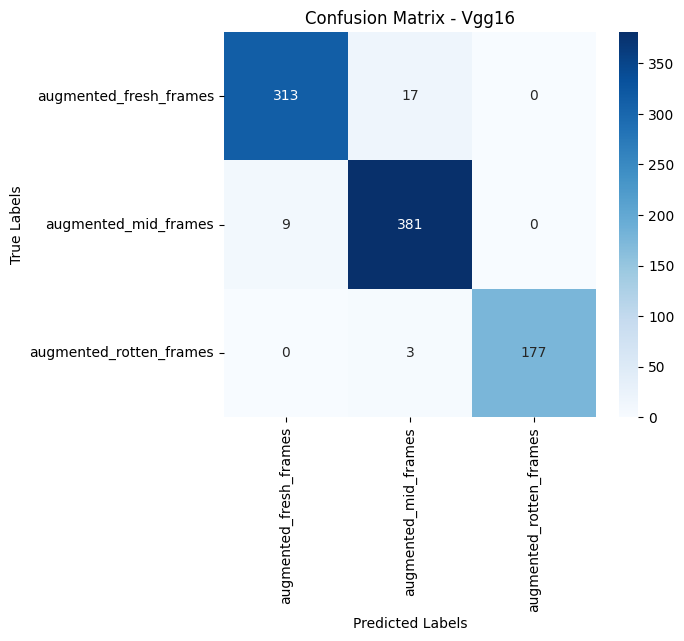

In [ ]:
#confusion mat
cm_vgg = confusion_matrix(y_true_vgg, y_pred_vgg)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_vgg, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Vgg16')
plt.show()

## MobileNetV2


In [ ]:
from tensorflow.keras.applications.mobilenet import preprocess_input

datagen_mobilenet = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.3
)

#Loading training data
train_data_mobilenet = datagen_mobilenet.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

#Loading validation data
val_data_mobilenet = datagen_mobilenet.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2100 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [ ]:
base_model = MobileNetV2(input_shape=(img_size[0], img_size[1], 3), include_top=False, weights='imagenet')
base_model.trainable = False

model_mobilenetv2 = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
model_mobilenetv2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model_mobilenetv2.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,586,691 (9.87 MB)

 Trainable params: 328,707 (1.25 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
checkpoint_mobilenet = ModelCheckpoint(
    'best_model_mobilenet.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

start_mobilenetv2 = time.time()

history_mobilenetv2 = model_mobilenetv2.fit(
    train_data_mobilenet,
    epochs=50,
    validation_data=val_data_mobilenet,
    callbacks=[checkpoint_mobilenet]
)

end_mobilenetv2 = time.time()
runtime_mobilenetv2 = end_mobilenetv2 - start_mobilenetv2

print(f"Training Time for MobileNetV2 model: {runtime_mobilenetv2:.2f} seconds")

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.9509 - loss: 0.1207
Epoch 1: val_accuracy improved from -inf to 0.93667, saving model to best_model_mobilenet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 331ms/step - accuracy: 0.9509 - loss: 0.1208 - val_accuracy: 0.9367 - val_loss: 0.1276
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9488 - loss: 0.1060
Epoch 2: val_accuracy improved from 0.93667 to 0.95444, saving model to best_model_mobilenet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 329ms/step - accuracy: 0.9489 - loss: 0.1061 - val_accuracy: 0.9544 - val_loss: 0.1012
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9556 - loss: 0.1005
Epoch 3: val_accuracy improved from 0.95444 to 0.96000, saving model to best_model_mobilenet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 321ms/step - accuracy: 0.9556 - loss: 0.1008 - val_accuracy: 0.9600 - val_loss: 0.0876
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step - accuracy: 0.9643 - loss: 0.0858
Epoch 4: val_accuracy did not improve from 0.96000
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 324ms/step - accuracy: 0.9644 - loss: 0.0858 - val_accuracy: 0.9589 - val_loss: 0.0842
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step - accuracy: 0.9642 - loss: 0.0850
Epoch 5: val_accuracy did not improve from 0.96000
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 323ms/step - accuracy: 0.9643 - loss: 0.0848 - val_accuracy: 0.9600 - val_loss: 0.0999
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9628 - loss: 0.0860
Epoch 6: val_accuracy improved from 0.96000 to 0.96222, saving model to best_model_mobilenet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 321ms/step - accuracy: 0.9628 - loss: 0.0861 - val_accuracy: 0.9622 - val_loss: 0.0884
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9666 - loss: 0.0748
Epoch 7: val_accuracy did not improve from 0.96222
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 332ms/step - accuracy: 0.9666 - loss: 0.0749 - val_accuracy: 0.9567 - val_loss: 0.0935
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step - accuracy: 0.9736 - loss: 0.0560
Epoch 8: val_accuracy did not improve from 0.96222
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 317ms/step - accuracy: 0.9737 - loss: 0.0559 - val_accuracy: 0.9578 - val_loss: 0.1014
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.9681 - loss: 0.0651
Epoch 9: val_accuracy did not improve from 0.96222
66/66 ━━━━━━━━━━━━━━━━━━━━ 45s 387ms/step - accuracy: 0.9682 - loss: 0.0650 - val_accuracy: 0.9578 - val_loss: 0.0818
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9736 - loss: 0.0617
Epoch 10: val_accuracy did not

66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 328ms/step - accuracy: 0.9881 - loss: 0.0338 - val_accuracy: 0.9667 - val_loss: 0.0963
Epoch 19/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9851 - loss: 0.0334
Epoch 19: val_accuracy did not improve from 0.96667
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 381ms/step - accuracy: 0.9852 - loss: 0.0334 - val_accuracy: 0.9556 - val_loss: 0.1228
Epoch 20/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step - accuracy: 0.9869 - loss: 0.0302
Epoch 20: val_accuracy did not improve from 0.96667
66/66 ━━━━━━━━━━━━━━━━━━━━ 21s 317ms/step - accuracy: 0.9869 - loss: 0.0303 - val_accuracy: 0.9600 - val_loss: 0.1130
Epoch 21/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9827 - loss: 0.0434
Epoch 21: val_accuracy did not improve from 0.96667
66/66 ━━━━━━━━━━━━━━━━━━━━ 22s 337ms/step - accuracy: 0.9827 - loss: 0.0434 - val_accuracy: 0.9578 - val_loss: 0.1138
Epoch 22/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.9875 - loss: 0.0281
Epoch 22: val_accuracy d

In [ ]:
model_mobilenet = load_model('best_model_mobilenet.h5')

In [ ]:
loss_mobilenetv2, accuracy_mobilenetv2 = model_mobilenet.evaluate(val_data_mobilenet)
print(f"Validation Accuracy: {accuracy_mobilenetv2:.4f}, Validation Loss: {loss_mobilenetv2:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 11s 242ms/step - accuracy: 0.9698 - loss: 0.0866
Validation Accuracy: 0.9667, Validation Loss: 0.0963


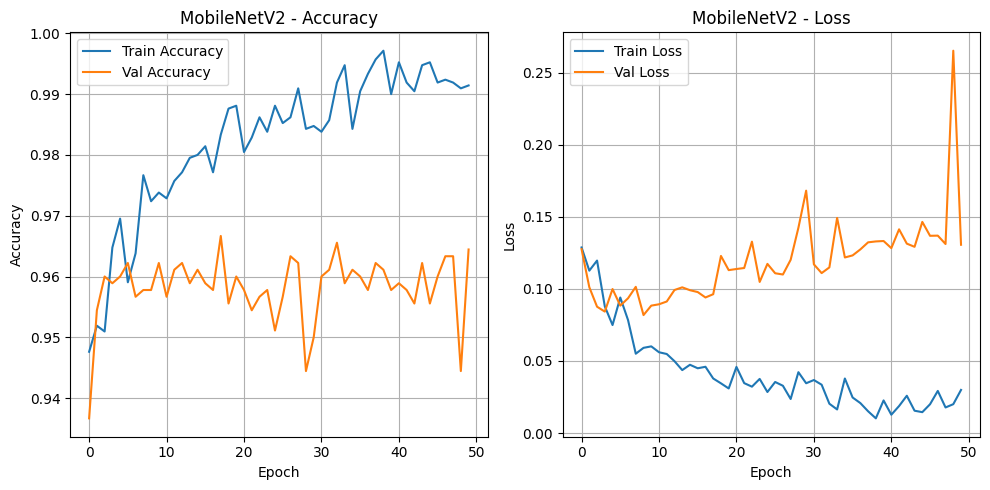

In [ ]:
#Plots for MobileNetV2 Accuracy and loss
plt.figure(figsize=(10, 5))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_mobilenetv2.history['accuracy'], label='Train Accuracy')
plt.plot(history_mobilenetv2.history['val_accuracy'], label='Val Accuracy')
plt.title('MobileNetV2 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

#Loss
plt.subplot(1, 2, 2)
plt.plot(history_mobilenetv2.history['loss'], label='Train Loss')
plt.plot(history_mobilenetv2.history['val_loss'], label='Val Loss')
plt.title('MobileNetV2 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

#Cnfusion matrix
#Prediction on validation data
val_pred_mobilenetv2 = model_mobilenet.predict(val_data_mobilenet)
y_pred_mobilenetv2 = np.argmax(val_pred_mobilenetv2, axis=1)

y_true_mobilenetv2 = val_data_mobilenet.classes

class_names = list(val_data.class_indices.keys())

29/29 ━━━━━━━━━━━━━━━━━━━━ 15s 348ms/step


In [ ]:
report_mobilenetv2 = classification_report(y_true_mobilenetv2, y_pred_mobilenetv2, target_names=class_names)
print("Classification Report - MobileNetV2")
print(report_mobilenetv2)

Classification Report - MobileNetV2
                         precision    recall  f1-score   support

 augmented_fresh_frames       0.95      0.97      0.96       330
   augmented_mid_frames       0.97      0.96      0.96       390
augmented_rotten_frames       0.99      0.98      0.99       180

               accuracy                           0.97       900
              macro avg       0.97      0.97      0.97       900
           weighted avg       0.97      0.97      0.97       900



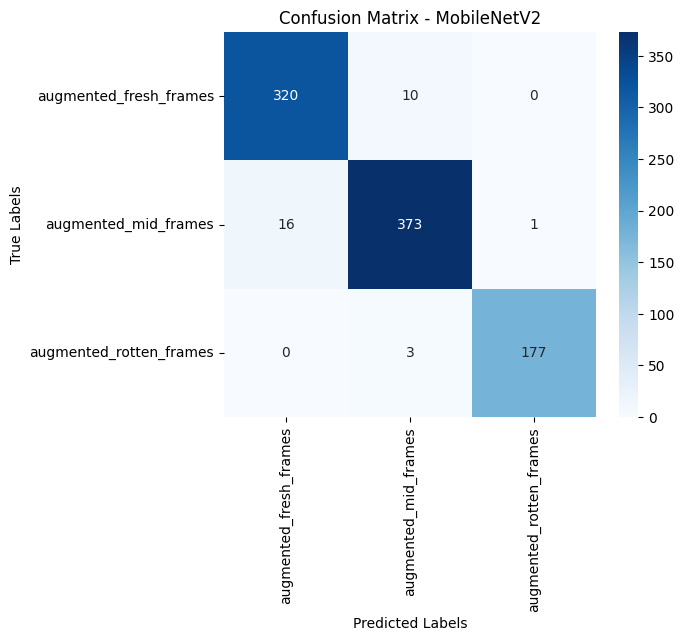

In [ ]:
#confusion matrix
cm_mobilenetv2 = confusion_matrix(y_true_mobilenetv2, y_pred_mobilenetv2)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_mobilenetv2, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - MobileNetV2")
plt.show()

## DenseNet201

In [ ]:
#Scaled values using preprocess_input
from tensorflow.keras.applications.densenet import preprocess_input

datagen_preprocessed = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.3
)

#Training data
train_data_preprocessed = datagen_preprocessed.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

#Validation data
val_data_preprocessed = datagen_preprocessed.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2100 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import DenseNet201

#Loading DenseNet201
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

#Building Model
model_densenet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
#Compilation
model_densenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Model summary
model_densenet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet201 (Functional)        │ (None, 7, 7, 1920)     │    18,321,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1920)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       491,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,814,531 (71.77 MB)

 Trainable params: 492,547 (1.88 MB)

 Non-trainable params: 18,321,984 (69.89 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_densenet = ModelCheckpoint(
    'best_model_densenet.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

start_densenet = time.time()

history_densenet = model_densenet.fit(
    train_data_preprocessed,
    epochs=50,
    validation_data=val_data_preprocessed,
    callbacks=[checkpoint_densenet]
)

end_densenet = time.time()
runtime_densenet = end_densenet - start_densenet

print(f"Training Time for DenseNet201 model: {runtime_densenet:.2f} seconds")

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 604ms/step - accuracy: 0.7732 - loss: 0.5918
Epoch 1: val_accuracy improved from -inf to 0.91556, saving model to best_model_densenet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.7746 - loss: 0.5885 - val_accuracy: 0.9156 - val_loss: 0.1865
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step - accuracy: 0.9436 - loss: 0.1650
Epoch 2: val_accuracy improved from 0.91556 to 0.94889, saving model to best_model_densenet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 469ms/step - accuracy: 0.9436 - loss: 0.1649 - val_accuracy: 0.9489 - val_loss: 0.1304
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step - accuracy: 0.9473 - loss: 0.1417
Epoch 3: val_accuracy improved from 0.94889 to 0.95111, saving model to best_model_densenet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 621ms/step - accuracy: 0.9474 - loss: 0.1415 - val_accuracy: 0.9511 - val_loss: 0.1497
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.9401 - loss: 0.1461
Epoch 4: val_accuracy improved from 0.95111 to 0.95556, saving model to best_model_densenet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 455ms/step - accuracy: 0.9402 - loss: 0.1457 - val_accuracy: 0.9556 - val_loss: 0.0898
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9503 - loss: 0.1077
Epoch 5: val_accuracy improved from 0.95556 to 0.96222, saving model to best_model_densenet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 443ms/step - accuracy: 0.9503 - loss: 0.1077 - val_accuracy: 0.9622 - val_loss: 0.0856
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step - accuracy: 0.9634 - loss: 0.0838
Epoch 6: val_accuracy did not improve from 0.96222
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 460ms/step - accuracy: 0.9634 - loss: 0.0839 - val_accuracy: 0.9489 - val_loss: 0.0954
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.9577 - loss: 0.0898
Epoch 7: val_accuracy improved from 0.96222 to 0.96333, saving model to best_model_densenet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 405ms/step - accuracy: 0.9577 - loss: 0.0898 - val_accuracy: 0.9633 - val_loss: 0.0977
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9570 - loss: 0.1010
Epoch 8: val_accuracy did not improve from 0.96333
66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 410ms/step - accuracy: 0.9570 - loss: 0.1009 - val_accuracy: 0.9611 - val_loss: 0.0821
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.9646 - loss: 0.0816
Epoch 9: val_accuracy did not improve from 0.96333
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 379ms/step - accuracy: 0.9646 - loss: 0.0816 - val_accuracy: 0.9600 - val_loss: 0.0825
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9632 - loss: 0.0752
Epoch 10: val_accuracy did not improve from 0.96333
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 403ms/step - accuracy: 0.9631 - loss: 0.0754 - val_accuracy: 0.9578 - val_loss: 0.1018
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.9585 - loss: 0.0997
Epoch 11: val_accuracy did n

66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 407ms/step - accuracy: 0.9885 - loss: 0.0278 - val_accuracy: 0.9644 - val_loss: 0.0983
Epoch 39/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9805 - loss: 0.0434
Epoch 39: val_accuracy did not improve from 0.96444
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 408ms/step - accuracy: 0.9805 - loss: 0.0434 - val_accuracy: 0.9611 - val_loss: 0.0922
Epoch 40/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9872 - loss: 0.0360
Epoch 40: val_accuracy did not improve from 0.96444
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 371ms/step - accuracy: 0.9872 - loss: 0.0360 - val_accuracy: 0.9611 - val_loss: 0.0908
Epoch 41/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.9894 - loss: 0.0306
Epoch 41: val_accuracy did not improve from 0.96444
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 371ms/step - accuracy: 0.9894 - loss: 0.0306 - val_accuracy: 0.9644 - val_loss: 0.0974
Epoch 42/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9871 - loss: 0.0326
Epoch 42: val_accuracy d

In [ ]:
model_densenet = load_model('best_model_densenet.h5')

In [ ]:
loss_densenet, accuracy_densenet = model_densenet.evaluate(val_data_preprocessed)
print(f"Validation Accuracy: {accuracy_densenet:.4f}, Validation Loss: {loss_densenet:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 38s 665ms/step - accuracy: 0.9698 - loss: 0.0835
Validation Accuracy: 0.9644, Validation Loss: 0.0983


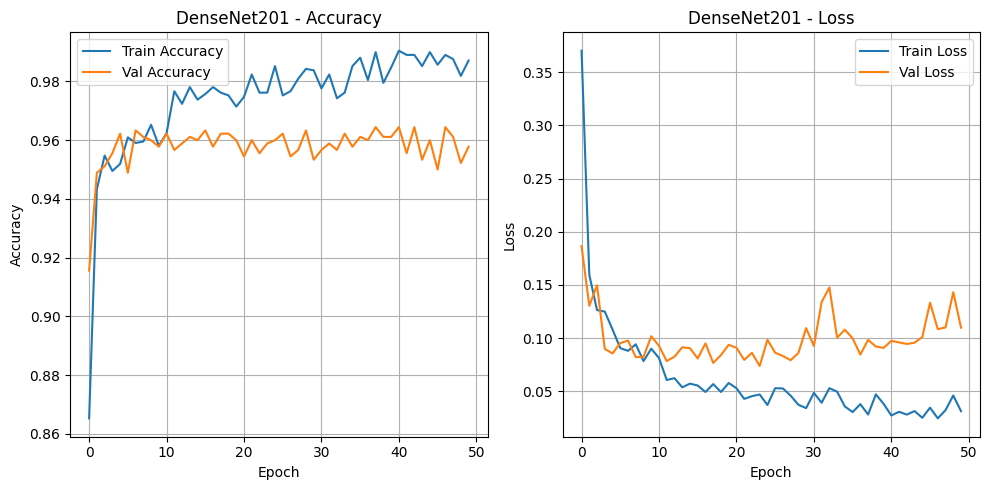

In [ ]:
#Plots for DenseNet201 Accuracy and loss
plt.figure(figsize=(10, 5))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_densenet.history['accuracy'], label='Train Accuracy')
plt.plot(history_densenet.history['val_accuracy'], label='Val Accuracy')
plt.title('DenseNet201 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

#Loss
plt.subplot(1, 2, 2)
plt.plot(history_densenet.history['loss'], label='Train Loss')
plt.plot(history_densenet.history['val_loss'], label='Val Loss')
plt.title('DenseNet201 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Cnfusion matrix
#Prediction on validation data
val_pred_densenet = model_densenet.predict(val_data_preprocessed)
y_pred_densenet = np.argmax(val_pred_densenet, axis=1)

y_true_densenet = val_data_preprocessed.classes

class_names = list(val_data_preprocessed.class_indices.keys())

29/29 ━━━━━━━━━━━━━━━━━━━━ 60s 1s/step


In [ ]:
# Classification report
report_densenet = classification_report(y_true_densenet, y_pred_densenet, target_names=class_names)
print("Classification Report - DenseNet")
print(report_densenet)

Classification Report - DenseNet
                         precision    recall  f1-score   support

 augmented_fresh_frames       0.93      0.98      0.95       330
   augmented_mid_frames       0.98      0.94      0.96       390
augmented_rotten_frames       1.00      1.00      1.00       180

               accuracy                           0.96       900
              macro avg       0.97      0.97      0.97       900
           weighted avg       0.97      0.96      0.96       900



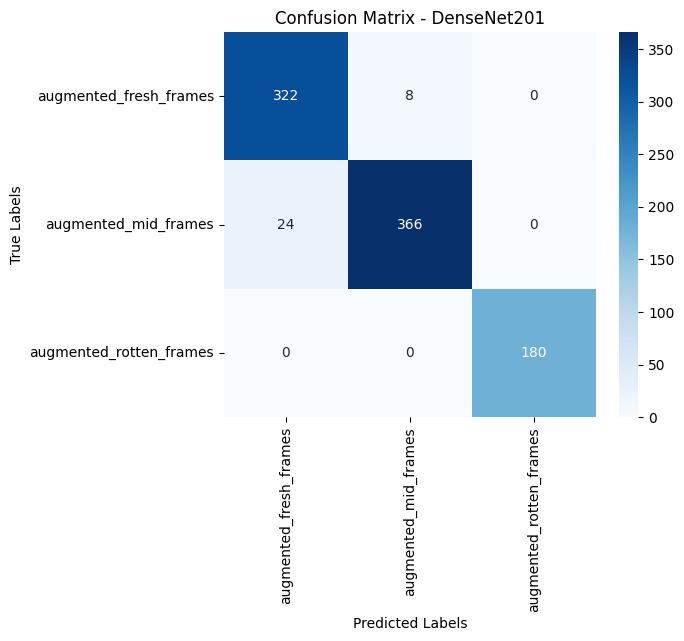

In [ ]:
#confusion mat
cm = confusion_matrix(y_true_densenet, y_pred_densenet)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - DenseNet201')
plt.show()

## InceptionV3

In [ ]:
from tensorflow.keras.applications.inception_v3 import preprocess_input

datagen_preprocessed = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.3
)

# Load training data using datagen_preprocessed
train_data_inception = datagen_preprocessed.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load validation data using datagen_preprocessed
val_data_inception = datagen_preprocessed.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2100 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import InceptionV3

#Loading InceptionV3
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

#Model
model_inception = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
# Compile
model_inception.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
model_inception.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ (None, 5, 5, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,328,099 (85.17 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [ ]:
checkpoint_inception = ModelCheckpoint(
    'best_model_inception.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

start_inception = time.time()

history_inception = model_inception.fit(
    train_data_inception,
    epochs=50,
    validation_data=val_data_inception,
    callbacks=[checkpoint_inception]
)

end_inception = time.time()
runtime_inception = end_inception - start_inception

print(f"Training Time for InceptionV3 model: {runtime_inception:.2f} seconds")

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step - accuracy: 0.6315 - loss: 0.8844
Epoch 1: val_accuracy improved from -inf to 0.87333, saving model to best_model_inception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 72s 778ms/step - accuracy: 0.6332 - loss: 0.8808 - val_accuracy: 0.8733 - val_loss: 0.3460
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.8732 - loss: 0.3778
Epoch 2: val_accuracy improved from 0.87333 to 0.90444, saving model to best_model_inception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 51s 459ms/step - accuracy: 0.8733 - loss: 0.3773 - val_accuracy: 0.9044 - val_loss: 0.2885
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9149 - loss: 0.2732
Epoch 3: val_accuracy improved from 0.90444 to 0.91000, saving model to best_model_inception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 41s 456ms/step - accuracy: 0.9147 - loss: 0.2734 - val_accuracy: 0.9100 - val_loss: 0.2592
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.9092 - loss: 0.2527
Epoch 4: val_accuracy improved from 0.91000 to 0.91556, saving model to best_model_inception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 447ms/step - accuracy: 0.9093 - loss: 0.2526 - val_accuracy: 0.9156 - val_loss: 0.2317
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9073 - loss: 0.2626
Epoch 5: val_accuracy did not improve from 0.91556
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 449ms/step - accuracy: 0.9074 - loss: 0.2620 - val_accuracy: 0.9144 - val_loss: 0.2126
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9278 - loss: 0.2117
Epoch 6: val_accuracy improved from 0.91556 to 0.91889, saving model to best_model_inception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 458ms/step - accuracy: 0.9278 - loss: 0.2116 - val_accuracy: 0.9189 - val_loss: 0.2047
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 315ms/step - accuracy: 0.9388 - loss: 0.1763
Epoch 7: val_accuracy improved from 0.91889 to 0.92000, saving model to best_model_inception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 468ms/step - accuracy: 0.9387 - loss: 0.1763 - val_accuracy: 0.9200 - val_loss: 0.2004
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9414 - loss: 0.1668
Epoch 8: val_accuracy improved from 0.92000 to 0.93222, saving model to best_model_inception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 444ms/step - accuracy: 0.9414 - loss: 0.1668 - val_accuracy: 0.9322 - val_loss: 0.1842
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.9403 - loss: 0.1659
Epoch 9: val_accuracy did not improve from 0.93222
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 436ms/step - accuracy: 0.9403 - loss: 0.1657 - val_accuracy: 0.9189 - val_loss: 0.1854
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9486 - loss: 0.1382
Epoch 10: val_accuracy improved from 0.93222 to 0.93778, saving model to best_model_inception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 442ms/step - accuracy: 0.9485 - loss: 0.1383 - val_accuracy: 0.9378 - val_loss: 0.1665
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9485 - loss: 0.1404
Epoch 11: val_accuracy did not improve from 0.93778
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 425ms/step - accuracy: 0.9486 - loss: 0.1404 - val_accuracy: 0.9356 - val_loss: 0.1620
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.9541 - loss: 0.1250
Epoch 12: val_accuracy did not improve from 0.93778
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 436ms/step - accuracy: 0.9540 - loss: 0.1252 - val_accuracy: 0.9322 - val_loss: 0.1626
Epoch 13/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9576 - loss: 0.1268
Epoch 13: val_accuracy did not improve from 0.93778
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 420ms/step - accuracy: 0.9576 - loss: 0.1268 - val_accuracy: 0.9367 - val_loss: 0.1615
Epoch 14/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9707 - loss: 0.0966
Epoch 14: val_accuracy i

66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 436ms/step - accuracy: 0.9706 - loss: 0.0968 - val_accuracy: 0.9422 - val_loss: 0.1485
Epoch 15/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step - accuracy: 0.9657 - loss: 0.1050
Epoch 15: val_accuracy improved from 0.94222 to 0.94444, saving model to best_model_inception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 444ms/step - accuracy: 0.9656 - loss: 0.1051 - val_accuracy: 0.9444 - val_loss: 0.1417
Epoch 16/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9646 - loss: 0.0962
Epoch 16: val_accuracy improved from 0.94444 to 0.94556, saving model to best_model_inception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 432ms/step - accuracy: 0.9645 - loss: 0.0963 - val_accuracy: 0.9456 - val_loss: 0.1433
Epoch 17/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9577 - loss: 0.1029
Epoch 17: val_accuracy improved from 0.94556 to 0.94778, saving model to best_model_inception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 469ms/step - accuracy: 0.9577 - loss: 0.1029 - val_accuracy: 0.9478 - val_loss: 0.1427
Epoch 18/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9766 - loss: 0.0808
Epoch 18: val_accuracy improved from 0.94778 to 0.95111, saving model to best_model_inception.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 38s 418ms/step - accuracy: 0.9764 - loss: 0.0810 - val_accuracy: 0.9511 - val_loss: 0.1374
Epoch 19/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9738 - loss: 0.0803
Epoch 19: val_accuracy did not improve from 0.95111
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 442ms/step - accuracy: 0.9737 - loss: 0.0804 - val_accuracy: 0.9467 - val_loss: 0.1378
Epoch 20/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9694 - loss: 0.0881
Epoch 20: val_accuracy did not improve from 0.95111
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 415ms/step - accuracy: 0.9694 - loss: 0.0881 - val_accuracy: 0.9411 - val_loss: 0.1411
Epoch 21/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.9728 - loss: 0.0778
Epoch 21: val_accuracy did not improve from 0.95111
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 394ms/step - accuracy: 0.9728 - loss: 0.0779 - val_accuracy: 0.9467 - val_loss: 0.1350
Epoch 22/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9753 - loss: 0.0755
Epoch 22: val_accuracy i

66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 424ms/step - accuracy: 0.9753 - loss: 0.0755 - val_accuracy: 0.9533 - val_loss: 0.1303
Epoch 23/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.9681 - loss: 0.0783
Epoch 23: val_accuracy did not improve from 0.95333
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 443ms/step - accuracy: 0.9681 - loss: 0.0783 - val_accuracy: 0.9500 - val_loss: 0.1334
Epoch 24/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9679 - loss: 0.0825
Epoch 24: val_accuracy did not improve from 0.95333
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 424ms/step - accuracy: 0.9679 - loss: 0.0825 - val_accuracy: 0.9378 - val_loss: 0.1504
Epoch 25/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9765 - loss: 0.0688
Epoch 25: val_accuracy did not improve from 0.95333
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 419ms/step - accuracy: 0.9765 - loss: 0.0688 - val_accuracy: 0.9511 - val_loss: 0.1269
Epoch 26/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.9766 - loss: 0.0675
Epoch 26: val_accuracy d

66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 450ms/step - accuracy: 0.9849 - loss: 0.0508 - val_accuracy: 0.9556 - val_loss: 0.1194
Epoch 32/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step - accuracy: 0.9858 - loss: 0.0495
Epoch 32: val_accuracy did not improve from 0.95556
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 443ms/step - accuracy: 0.9857 - loss: 0.0495 - val_accuracy: 0.9500 - val_loss: 0.1224
Epoch 33/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step - accuracy: 0.9849 - loss: 0.0488
Epoch 33: val_accuracy did not improve from 0.95556
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 467ms/step - accuracy: 0.9848 - loss: 0.0489 - val_accuracy: 0.9511 - val_loss: 0.1173
Epoch 34/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step - accuracy: 0.9824 - loss: 0.0515
Epoch 34: val_accuracy did not improve from 0.95556
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 439ms/step - accuracy: 0.9825 - loss: 0.0514 - val_accuracy: 0.9500 - val_loss: 0.1353
Epoch 35/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 323ms/step - accuracy: 0.9822 - loss: 0.0453
Epoch 35: val_accuracy d

In [ ]:
model_inception = load_model("best_model_inception.h5")

In [ ]:
loss_inception, accuracy_inception = model_inception.evaluate(val_data_inception)
print(f"Validation Accuracy: {accuracy_inception:.4f}, Validation Loss: {loss_inception:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 17s 373ms/step - accuracy: 0.9501 - loss: 0.1212
Validation Accuracy: 0.9556, Validation Loss: 0.1194


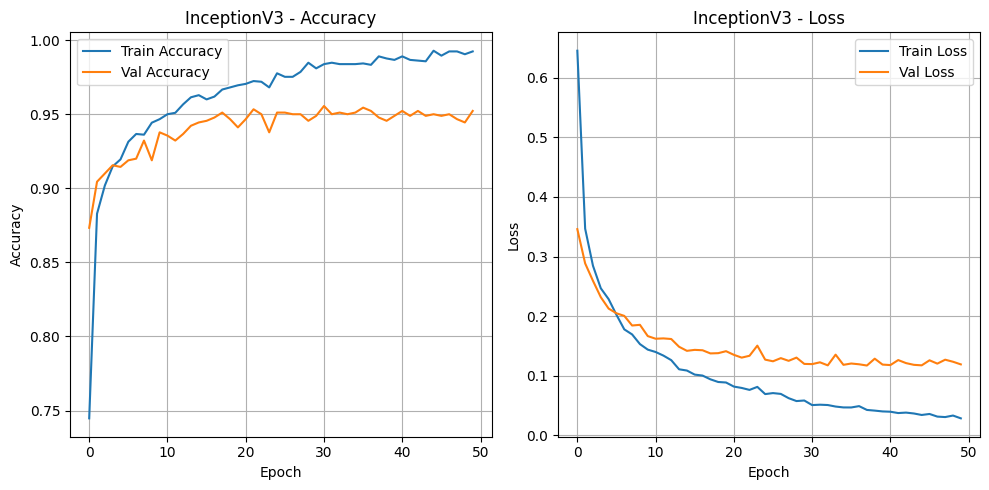

In [ ]:
#Plots for InceptionV3 Accuracy and loss
plt.figure(figsize=(10, 5))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_inception.history['accuracy'], label='Train Accuracy')
plt.plot(history_inception.history['val_accuracy'], label='Val Accuracy')
plt.title('InceptionV3 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

#Loss
plt.subplot(1, 2, 2)
plt.plot(history_inception.history['loss'], label='Train Loss')
plt.plot(history_inception.history['val_loss'], label='Val Loss')
plt.title('InceptionV3 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Cnfusion matrix
#Prediction on validation data
val_pred_inception = model_inception.predict(val_data_inception)
y_pred_inception = np.argmax(val_pred_inception, axis=1)

y_true_inception = val_data_inception.classes

class_names = list(val_data_inception.class_indices.keys())

29/29 ━━━━━━━━━━━━━━━━━━━━ 24s 513ms/step


In [ ]:
# Classification report
report_inception = classification_report(y_true_inception, y_pred_inception, target_names=class_names)
print("Classification Report - Inception")
print(report_inception)

Classification Report - Inception
                         precision    recall  f1-score   support

 augmented_fresh_frames       0.97      0.94      0.95       330
   augmented_mid_frames       0.93      0.97      0.95       390
augmented_rotten_frames       0.98      0.96      0.97       180

               accuracy                           0.96       900
              macro avg       0.96      0.96      0.96       900
           weighted avg       0.96      0.96      0.96       900



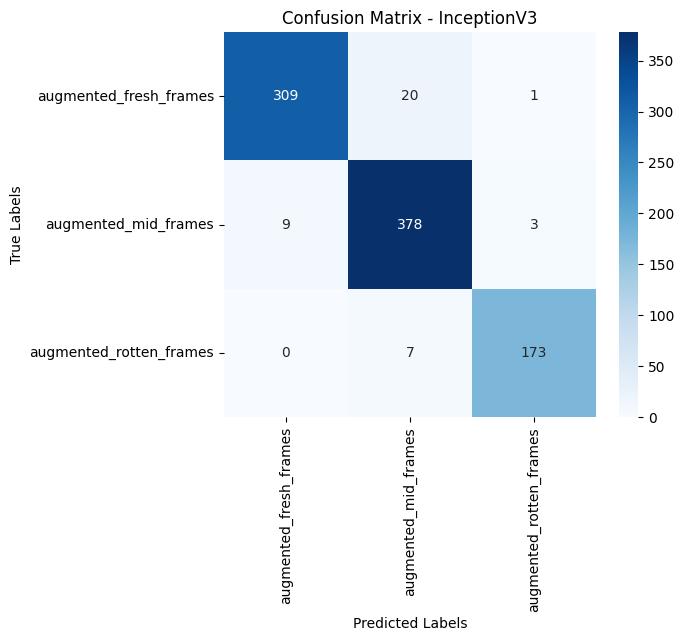

In [ ]:
cm_inception = confusion_matrix(y_true_inception, y_pred_inception)
#show cm
plt.figure(figsize=(6, 5))
sns.heatmap(cm_inception, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - InceptionV3')
plt.show()

## EfficientNetB0

In [ ]:
from tensorflow.keras.applications.efficientnet import preprocess_input

datagen_preprocessed = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.3
)

#Training data
train_data_efficientnet = datagen_preprocessed.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

#Validation data
val_data_efficientnet = datagen_preprocessed.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2100 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import EfficientNetB0

#Loading EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

#Model Building
model_efficientnet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
#compilation
model_efficientnet.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

#Model summary
model_efficientnet.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,278 (16.70 MB)

 Trainable params: 328,707 (1.25 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [ ]:
checkpoint_efficientnet = ModelCheckpoint(
    'best_model_efficientnet.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

start_efficientnet = time.time()

history_efficientnet = model_efficientnet.fit(
    train_data_efficientnet,
    epochs=50,
    validation_data=val_data_efficientnet,
    callbacks=[checkpoint_efficientnet]
)

end_efficientnet = time.time()
runtime_efficientnet = end_efficientnet - start_efficientnet

print(f"Training Time for EfficientNetB0 model: {runtime_efficientnet:.2f} seconds")

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step - accuracy: 0.8030 - loss: 0.4797
Epoch 1: val_accuracy improved from -inf to 0.94333, saving model to best_model_efficientnet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 74s 752ms/step - accuracy: 0.8042 - loss: 0.4772 - val_accuracy: 0.9433 - val_loss: 0.1305
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step - accuracy: 0.9377 - loss: 0.1553
Epoch 2: val_accuracy improved from 0.94333 to 0.96111, saving model to best_model_efficientnet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 421ms/step - accuracy: 0.9377 - loss: 0.1553 - val_accuracy: 0.9611 - val_loss: 0.1053
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.9514 - loss: 0.1177
Epoch 3: val_accuracy did not improve from 0.96111
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 411ms/step - accuracy: 0.9514 - loss: 0.1178 - val_accuracy: 0.9611 - val_loss: 0.1148
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9525 - loss: 0.1186
Epoch 4: val_accuracy improved from 0.96111 to 0.96222, saving model to best_model_efficientnet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 390ms/step - accuracy: 0.9524 - loss: 0.1186 - val_accuracy: 0.9622 - val_loss: 0.0974
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.9574 - loss: 0.1108
Epoch 5: val_accuracy did not improve from 0.96222
66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 404ms/step - accuracy: 0.9574 - loss: 0.1109 - val_accuracy: 0.9511 - val_loss: 0.0920
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.9537 - loss: 0.1040
Epoch 6: val_accuracy did not improve from 0.96222
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 411ms/step - accuracy: 0.9538 - loss: 0.1040 - val_accuracy: 0.9589 - val_loss: 0.0838
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9651 - loss: 0.0907
Epoch 7: val_accuracy did not improve from 0.96222
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 401ms/step - accuracy: 0.9650 - loss: 0.0908 - val_accuracy: 0.9544 - val_loss: 0.0872
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9703 - loss: 0.0760
Epoch 8: val_accuracy did not i

66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 389ms/step - accuracy: 0.9663 - loss: 0.0655 - val_accuracy: 0.9656 - val_loss: 0.0638
Epoch 25/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.9752 - loss: 0.0498
Epoch 25: val_accuracy did not improve from 0.96556
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 363ms/step - accuracy: 0.9751 - loss: 0.0499 - val_accuracy: 0.9644 - val_loss: 0.0726
Epoch 26/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step - accuracy: 0.9750 - loss: 0.0507
Epoch 26: val_accuracy did not improve from 0.96556
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 396ms/step - accuracy: 0.9750 - loss: 0.0507 - val_accuracy: 0.9600 - val_loss: 0.0707
Epoch 27/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.9735 - loss: 0.0515
Epoch 27: val_accuracy did not improve from 0.96556
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 383ms/step - accuracy: 0.9734 - loss: 0.0516 - val_accuracy: 0.9600 - val_loss: 0.0747
Epoch 28/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9719 - loss: 0.0634
Epoch 28: val_accuracy d

66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 437ms/step - accuracy: 0.9656 - loss: 0.0672 - val_accuracy: 0.9678 - val_loss: 0.0773
Epoch 33/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step - accuracy: 0.9702 - loss: 0.0595
Epoch 33: val_accuracy did not improve from 0.96778
66/66 ━━━━━━━━━━━━━━━━━━━━ 38s 395ms/step - accuracy: 0.9702 - loss: 0.0596 - val_accuracy: 0.9600 - val_loss: 0.0667
Epoch 34/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9797 - loss: 0.0500
Epoch 34: val_accuracy did not improve from 0.96778
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 411ms/step - accuracy: 0.9796 - loss: 0.0500 - val_accuracy: 0.9656 - val_loss: 0.0797
Epoch 35/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.9753 - loss: 0.0568
Epoch 35: val_accuracy did not improve from 0.96778
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 403ms/step - accuracy: 0.9753 - loss: 0.0568 - val_accuracy: 0.9600 - val_loss: 0.0667
Epoch 36/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.9716 - loss: 0.0587
Epoch 36: val_accuracy d

In [ ]:
model_efficientnet = load_model("best_model_efficientnet.h5")

In [ ]:
loss_efficientnet, accuracy_efficientnet = model_efficientnet.evaluate(val_data_efficientnet)
print(f"Validation Accuracy: {accuracy_efficientnet:.8f}, Validation Loss: {loss_efficientnet:.8f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 416ms/step - accuracy: 0.9527 - loss: 0.1289
Validation Accuracy: 0.92333335, Validation Loss: 0.21164703


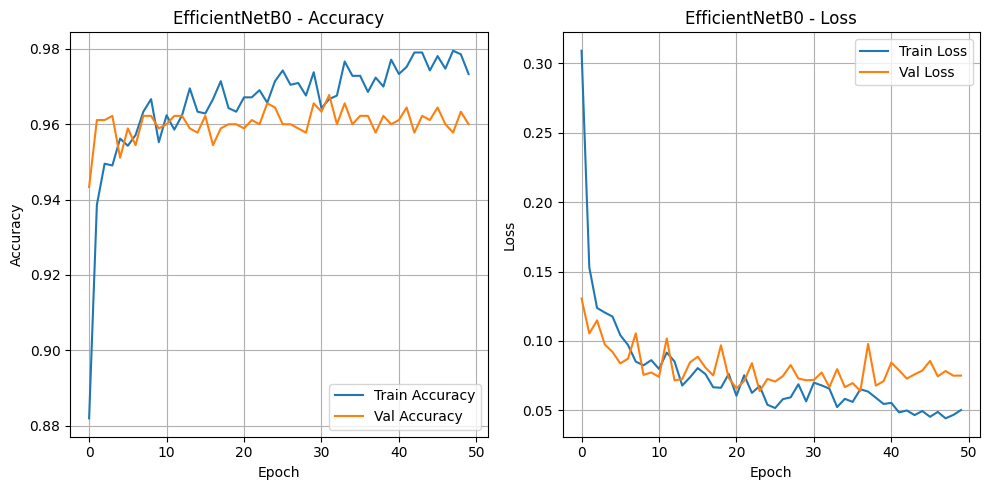

In [ ]:
#Plots for EfficientNetB0 Accuracy and loss
plt.figure(figsize=(10, 5))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_efficientnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_efficientnet.history['val_accuracy'], label='Val Accuracy')
plt.title('EfficientNetB0 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

#Loss
plt.subplot(1, 2, 2)
plt.plot(history_efficientnet.history['loss'], label='Train Loss')
plt.plot(history_efficientnet.history['val_loss'], label='Val Loss')
plt.title('EfficientNetB0 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Cnfusion matrix
#Prediction on validation data
val_pred_efficientb0 = model_efficientnet.predict(val_data_efficientnet)
y_pred_efficientb0 = np.argmax(val_pred_efficientb0, axis=1)

y_true_efficientb0 = val_data_efficientnet.classes

class_names = list(val_data_efficientnet.class_indices.keys())

29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 442ms/step


In [ ]:
# Classification report
report_efficientb0 = classification_report(y_true_efficientb0, y_pred_efficientb0, target_names=class_names)
print("Classification Report - EfficientNetB0")
print(report_efficientb0)

Classification Report - EfficientNetB0
                         precision    recall  f1-score   support

 augmented_fresh_frames       0.83      1.00      0.91       330
   augmented_mid_frames       1.00      0.83      0.90       390
augmented_rotten_frames       0.99      1.00      1.00       180

               accuracy                           0.92       900
              macro avg       0.94      0.94      0.94       900
           weighted avg       0.94      0.92      0.92       900



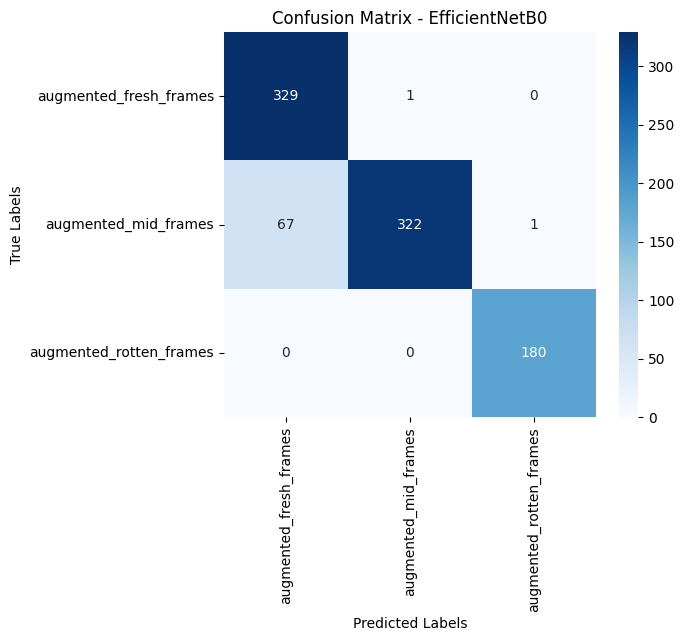

In [ ]:
cm_efficientb0 = confusion_matrix(y_true_efficientb0, y_pred_efficientb0)
#show cm
plt.figure(figsize=(6, 5))
sns.heatmap(cm_efficientb0, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - EfficientNetB0')
plt.show()

## NASNetMobile

In [ ]:
from tensorflow.keras.applications.nasnet  import preprocess_input

datagen_nasnet = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.3
)

#Training data
train_data_nasnet = datagen_nasnet.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

#Validation data
val_data_nasnet = datagen_nasnet.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2100 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import NASNetMobile

#Loading NASNetMobile
base_model = NASNetMobile(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

#Model Building
model_nasnet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

19993432/19993432 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [ ]:
#Compilation
model_nasnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Summary
model_nasnet.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ nasnet_mobile (Functional)      │ (None, 7, 7, 1056)     │     4,269,716 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1056)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │       270,592 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,541,079 (17.32 MB)

 Trainable params: 271,363 (1.04 MB)

 Non-trainable params: 4,269,716 (16.29 MB)

In [ ]:
checkpoint_nasnet = ModelCheckpoint(
    'best_model_nasnet.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

start_nasnet = time.time()

history_nasnet = model_nasnet.fit(
    train_data_nasnet,
    epochs=50,
    validation_data=val_data_nasnet,
    callbacks=[checkpoint_nasnet]
)

end_nasnet = time.time()
runtime_nasnet = end_nasnet - start_nasnet

print(f"Training Time for NASNetMobile model: {runtime_nasnet:.2f} seconds")

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.7738 - loss: 0.5288
Epoch 1: val_accuracy improved from -inf to 0.91111, saving model to best_model_nasnet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 108s 1s/step - accuracy: 0.7749 - loss: 0.5268 - val_accuracy: 0.9111 - val_loss: 0.2310
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9152 - loss: 0.2308
Epoch 2: val_accuracy improved from 0.91111 to 0.93111, saving model to best_model_nasnet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9153 - loss: 0.2306 - val_accuracy: 0.9311 - val_loss: 0.1757
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step - accuracy: 0.9185 - loss: 0.1980
Epoch 3: val_accuracy improved from 0.93111 to 0.93333, saving model to best_model_nasnet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 436ms/step - accuracy: 0.9186 - loss: 0.1981 - val_accuracy: 0.9333 - val_loss: 0.1811
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 312ms/step - accuracy: 0.9252 - loss: 0.1757
Epoch 4: val_accuracy did not improve from 0.93333
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 434ms/step - accuracy: 0.9252 - loss: 0.1756 - val_accuracy: 0.9211 - val_loss: 0.1955
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 321ms/step - accuracy: 0.9386 - loss: 0.1658
Epoch 5: val_accuracy improved from 0.93333 to 0.94111, saving model to best_model_nasnet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 457ms/step - accuracy: 0.9387 - loss: 0.1655 - val_accuracy: 0.9411 - val_loss: 0.1516
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.9521 - loss: 0.1145
Epoch 6: val_accuracy improved from 0.94111 to 0.95111, saving model to best_model_nasnet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 478ms/step - accuracy: 0.9520 - loss: 0.1147 - val_accuracy: 0.9511 - val_loss: 0.1257
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9553 - loss: 0.1130
Epoch 7: val_accuracy did not improve from 0.95111
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 428ms/step - accuracy: 0.9552 - loss: 0.1131 - val_accuracy: 0.9356 - val_loss: 0.1325
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9553 - loss: 0.1133
Epoch 8: val_accuracy improved from 0.95111 to 0.95333, saving model to best_model_nasnet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 441ms/step - accuracy: 0.9553 - loss: 0.1133 - val_accuracy: 0.9533 - val_loss: 0.1248
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9615 - loss: 0.1004
Epoch 9: val_accuracy did not improve from 0.95333
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 432ms/step - accuracy: 0.9614 - loss: 0.1006 - val_accuracy: 0.9367 - val_loss: 0.1676
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.9604 - loss: 0.1030
Epoch 10: val_accuracy did not improve from 0.95333
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 427ms/step - accuracy: 0.9604 - loss: 0.1031 - val_accuracy: 0.9511 - val_loss: 0.1111
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9586 - loss: 0.0894
Epoch 11: val_accuracy did not improve from 0.95333
66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 445ms/step - accuracy: 0.9586 - loss: 0.0895 - val_accuracy: 0.9311 - val_loss: 0.1337
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step - accuracy: 0.9591 - loss: 0.1036
Epoch 12: val_accuracy did

66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 445ms/step - accuracy: 0.9684 - loss: 0.0751 - val_accuracy: 0.9544 - val_loss: 0.1151
Epoch 21/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.9642 - loss: 0.0820
Epoch 21: val_accuracy did not improve from 0.95444
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 431ms/step - accuracy: 0.9643 - loss: 0.0820 - val_accuracy: 0.9533 - val_loss: 0.1271
Epoch 22/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step - accuracy: 0.9758 - loss: 0.0578
Epoch 22: val_accuracy did not improve from 0.95444
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 428ms/step - accuracy: 0.9758 - loss: 0.0578 - val_accuracy: 0.9456 - val_loss: 0.1532
Epoch 23/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9685 - loss: 0.0795
Epoch 23: val_accuracy did not improve from 0.95444
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 428ms/step - accuracy: 0.9686 - loss: 0.0794 - val_accuracy: 0.9533 - val_loss: 0.1305
Epoch 24/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step - accuracy: 0.9749 - loss: 0.0648
Epoch 24: val_accuracy d

66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 430ms/step - accuracy: 0.9792 - loss: 0.0549 - val_accuracy: 0.9556 - val_loss: 0.1234
Epoch 28/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step - accuracy: 0.9761 - loss: 0.0487
Epoch 28: val_accuracy did not improve from 0.95556
66/66 ━━━━━━━━━━━━━━━━━━━━ 30s 460ms/step - accuracy: 0.9761 - loss: 0.0487 - val_accuracy: 0.9533 - val_loss: 0.1295
Epoch 29/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.9778 - loss: 0.0502
Epoch 29: val_accuracy did not improve from 0.95556
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 420ms/step - accuracy: 0.9778 - loss: 0.0503 - val_accuracy: 0.9544 - val_loss: 0.1369
Epoch 30/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.9796 - loss: 0.0464
Epoch 30: val_accuracy did not improve from 0.95556
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 418ms/step - accuracy: 0.9795 - loss: 0.0464 - val_accuracy: 0.9533 - val_loss: 0.1143
Epoch 31/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.9793 - loss: 0.0527
Epoch 31: val_accuracy d

66/66 ━━━━━━━━━━━━━━━━━━━━ 29s 436ms/step - accuracy: 0.9780 - loss: 0.0425 - val_accuracy: 0.9578 - val_loss: 0.1191
Epoch 33/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.9814 - loss: 0.0400
Epoch 33: val_accuracy did not improve from 0.95778
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 429ms/step - accuracy: 0.9814 - loss: 0.0401 - val_accuracy: 0.9533 - val_loss: 0.1334
Epoch 34/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.9863 - loss: 0.0367
Epoch 34: val_accuracy did not improve from 0.95778
66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 419ms/step - accuracy: 0.9862 - loss: 0.0369 - val_accuracy: 0.9511 - val_loss: 0.1259
Epoch 35/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9849 - loss: 0.0389
Epoch 35: val_accuracy did not improve from 0.95778
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 417ms/step - accuracy: 0.9848 - loss: 0.0389 - val_accuracy: 0.9544 - val_loss: 0.1189
Epoch 36/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 287ms/step - accuracy: 0.9855 - loss: 0.0392
Epoch 36: val_accuracy d

In [ ]:
model_nasnet = load_model("best_model_nasnet.h5")

In [ ]:
loss_nasnet, accuracy_nasnet = model_nasnet.evaluate(val_data_nasnet)
print(f"Validation Accuracy: {accuracy_nasnet:.4f}, Validation Loss: {loss_nasnet:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 276ms/step - accuracy: 0.9559 - loss: 0.1191
Validation Accuracy: 0.9578, Validation Loss: 0.1191


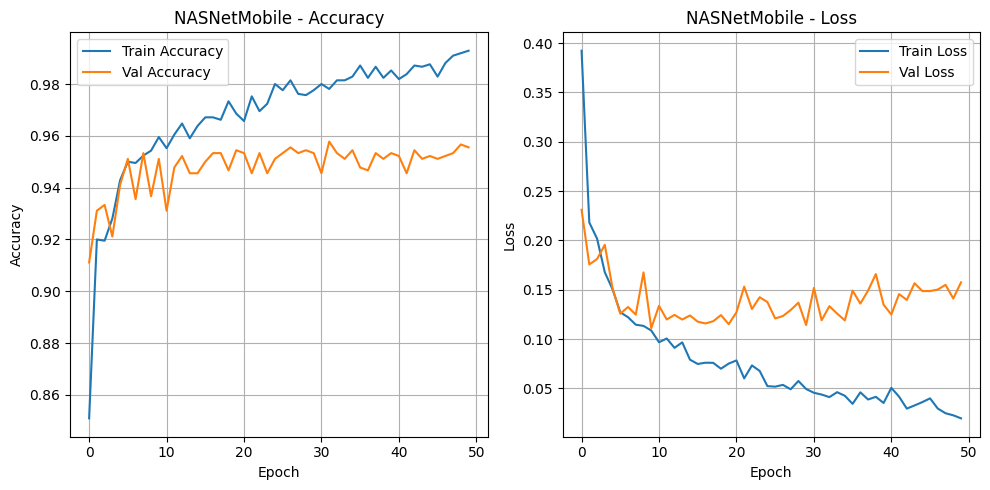

In [ ]:
#Plots for NASNetMobile Accuracy and loss
plt.figure(figsize=(10, 5))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_nasnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_nasnet.history['val_accuracy'], label='Val Accuracy')
plt.title('NASNetMobile - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

#Loss
plt.subplot(1, 2, 2)
plt.plot(history_nasnet.history['loss'], label='Train Loss')
plt.plot(history_nasnet.history['val_loss'], label='Val Loss')
plt.title('NASNetMobile - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Cnfusion matrix
#Prediction on validation data
val_pred_nasnet = model_nasnet.predict(val_data_nasnet)
y_pred_nasnet = np.argmax(val_pred_nasnet, axis=1)

y_true_nasnet = val_data_nasnet.classes

class_names = list(val_data_nasnet.class_indices.keys())

29/29 ━━━━━━━━━━━━━━━━━━━━ 39s 807ms/step


In [ ]:
# Classification report
report_nasnet = classification_report(y_true_nasnet, y_pred_nasnet, target_names=class_names)
print("Classification Report - NASNet")
print(report_nasnet)

Classification Report - NASNet
                         precision    recall  f1-score   support

 augmented_fresh_frames       0.97      0.94      0.96       330
   augmented_mid_frames       0.94      0.96      0.95       390
augmented_rotten_frames       0.98      0.97      0.97       180

               accuracy                           0.96       900
              macro avg       0.96      0.96      0.96       900
           weighted avg       0.96      0.96      0.96       900



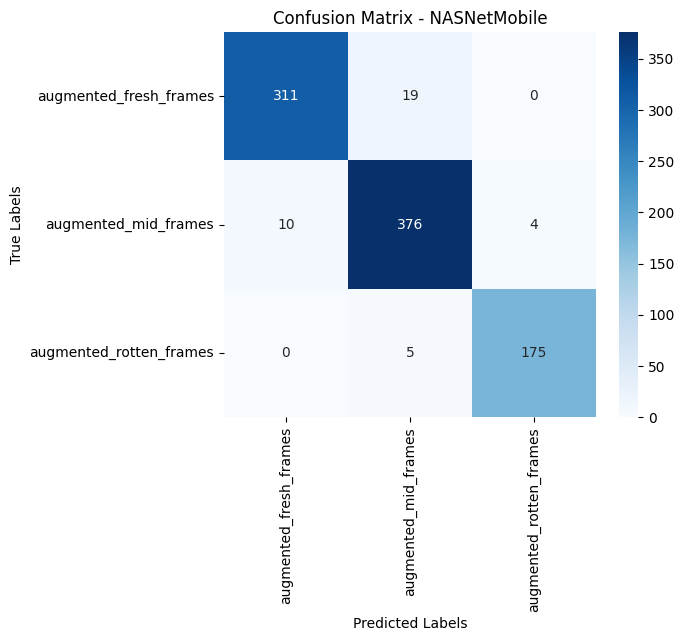

In [ ]:
cm_nasnet = confusion_matrix(y_true_nasnet, y_pred_nasnet)
#show cm
plt.figure(figsize=(6, 5))
sns.heatmap(cm_nasnet, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - NASNetMobile')
plt.show()

## ResNet50

In [ ]:
#Scaling values using preprocess_input
from tensorflow.keras.applications.resnet50 import preprocess_input

batch_size = 32
img_size = (224, 224)

datagen_preprocessed = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.3
)

# Load training data using datagen_preprocessed
train_data_resnet = datagen_preprocessed.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

# Load validation data using datagen_preprocessed
val_data_resnet = datagen_preprocessed.flow_from_directory(
    base_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 2100 images belonging to 3 classes.
Found 900 images belonging to 3 classes.


In [ ]:
from tensorflow.keras.applications import ResNet50

#Loading Resnet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

#model building
model_resnet = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(3, activation='softmax')
])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
#Compilation
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#Model summary
model_resnet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,113,027 (91.98 MB)

 Trainable params: 525,315 (2.00 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
checkpoint_resnet = ModelCheckpoint(
    'best_model_resnet.h5',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

start_resnet = time.time()

history_resnet = model_resnet.fit(
    train_data_resnet,
    epochs=50,
    validation_data=val_data_resnet,
    callbacks=[checkpoint_resnet]
)

end_resnet = time.time()
runtime_resnet = end_resnet - start_resnet

print(f"Training Time for ResNet50 model: {runtime_resnet:.2f} seconds")

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step - accuracy: 0.7594 - loss: 0.7465
Epoch 1: val_accuracy improved from -inf to 0.92444, saving model to best_model_resnet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 48s 533ms/step - accuracy: 0.7609 - loss: 0.7415 - val_accuracy: 0.9244 - val_loss: 0.1747
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9238 - loss: 0.1858
Epoch 2: val_accuracy improved from 0.92444 to 0.93889, saving model to best_model_resnet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 381ms/step - accuracy: 0.9239 - loss: 0.1856 - val_accuracy: 0.9389 - val_loss: 0.1361
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step - accuracy: 0.9323 - loss: 0.1510
Epoch 3: val_accuracy improved from 0.93889 to 0.94111, saving model to best_model_resnet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 470ms/step - accuracy: 0.9324 - loss: 0.1508 - val_accuracy: 0.9411 - val_loss: 0.1540
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step - accuracy: 0.9379 - loss: 0.1716
Epoch 4: val_accuracy improved from 0.94111 to 0.95444, saving model to best_model_resnet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 38s 573ms/step - accuracy: 0.9381 - loss: 0.1710 - val_accuracy: 0.9544 - val_loss: 0.1058
Epoch 5/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step - accuracy: 0.9529 - loss: 0.0967
Epoch 5: val_accuracy improved from 0.95444 to 0.95667, saving model to best_model_resnet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 357ms/step - accuracy: 0.9529 - loss: 0.0968 - val_accuracy: 0.9567 - val_loss: 0.1020
Epoch 6/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 255ms/step - accuracy: 0.9578 - loss: 0.0906
Epoch 6: val_accuracy improved from 0.95667 to 0.95778, saving model to best_model_resnet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 42s 380ms/step - accuracy: 0.9579 - loss: 0.0906 - val_accuracy: 0.9578 - val_loss: 0.1362
Epoch 7/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9522 - loss: 0.1080
Epoch 7: val_accuracy improved from 0.95778 to 0.95889, saving model to best_model_resnet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 390ms/step - accuracy: 0.9522 - loss: 0.1079 - val_accuracy: 0.9589 - val_loss: 0.0868
Epoch 8/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.9691 - loss: 0.0765
Epoch 8: val_accuracy improved from 0.95889 to 0.96111, saving model to best_model_resnet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 414ms/step - accuracy: 0.9691 - loss: 0.0764 - val_accuracy: 0.9611 - val_loss: 0.0856
Epoch 9/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9735 - loss: 0.0638
Epoch 9: val_accuracy did not improve from 0.96111
66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 354ms/step - accuracy: 0.9734 - loss: 0.0640 - val_accuracy: 0.9478 - val_loss: 0.1047
Epoch 10/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step - accuracy: 0.9675 - loss: 0.0749
Epoch 10: val_accuracy improved from 0.96111 to 0.96222, saving model to best_model_resnet.h5


66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 418ms/step - accuracy: 0.9675 - loss: 0.0748 - val_accuracy: 0.9622 - val_loss: 0.0855
Epoch 11/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.9632 - loss: 0.0791
Epoch 11: val_accuracy did not improve from 0.96222
66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 349ms/step - accuracy: 0.9633 - loss: 0.0791 - val_accuracy: 0.9567 - val_loss: 0.0937
Epoch 12/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9763 - loss: 0.0618
Epoch 12: val_accuracy did not improve from 0.96222
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 403ms/step - accuracy: 0.9763 - loss: 0.0618 - val_accuracy: 0.9578 - val_loss: 0.0881
Epoch 13/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.9688 - loss: 0.0577
Epoch 13: val_accuracy did not improve from 0.96222
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 403ms/step - accuracy: 0.9688 - loss: 0.0578 - val_accuracy: 0.9556 - val_loss: 0.0987
Epoch 14/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.9692 - loss: 0.0710
Epoch 14: val_accuracy d

66/66 ━━━━━━━━━━━━━━━━━━━━ 28s 425ms/step - accuracy: 0.9621 - loss: 0.0891 - val_accuracy: 0.9656 - val_loss: 0.1027
Epoch 16/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step - accuracy: 0.9781 - loss: 0.0499
Epoch 16: val_accuracy did not improve from 0.96556
66/66 ━━━━━━━━━━━━━━━━━━━━ 25s 378ms/step - accuracy: 0.9780 - loss: 0.0500 - val_accuracy: 0.9633 - val_loss: 0.0956
Epoch 17/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step - accuracy: 0.9666 - loss: 0.0760
Epoch 17: val_accuracy did not improve from 0.96556
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 374ms/step - accuracy: 0.9665 - loss: 0.0760 - val_accuracy: 0.9556 - val_loss: 0.1051
Epoch 18/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9754 - loss: 0.0614
Epoch 18: val_accuracy did not improve from 0.96556
66/66 ━━━━━━━━━━━━━━━━━━━━ 40s 358ms/step - accuracy: 0.9754 - loss: 0.0614 - val_accuracy: 0.9511 - val_loss: 0.0975
Epoch 19/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.9735 - loss: 0.0647
Epoch 19: val_accuracy d

66/66 ━━━━━━━━━━━━━━━━━━━━ 24s 367ms/step - accuracy: 0.9917 - loss: 0.0240 - val_accuracy: 0.9667 - val_loss: 0.1050
Epoch 50/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.9865 - loss: 0.0406
Epoch 50: val_accuracy did not improve from 0.96667
66/66 ━━━━━━━━━━━━━━━━━━━━ 23s 351ms/step - accuracy: 0.9865 - loss: 0.0405 - val_accuracy: 0.9656 - val_loss: 0.1094
Training Time for ResNet50 model: 1379.02 seconds


In [ ]:
model_resnet = load_model("best_model_resnet.h5")

In [ ]:
loss_resnet, accuracy_resnet = model_resnet.evaluate(val_data_resnet)
print(f"Validation Accuracy: {accuracy_resnet:.4f}, Validation Loss: {loss_resnet:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 308ms/step - accuracy: 0.9539 - loss: 0.1388
Validation Accuracy: 0.9667, Validation Loss: 0.1050


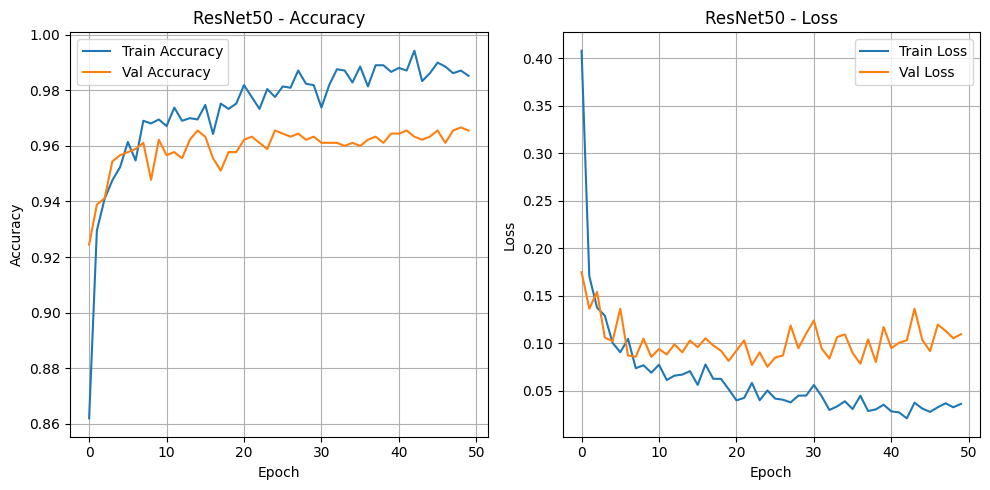

In [ ]:
#Plots for ResNet50 Accuracy and loss
plt.figure(figsize=(10, 5))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Train Accuracy')
plt.plot(history_resnet.history['val_accuracy'], label='Val Accuracy')
plt.title('ResNet50 - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

#Loss
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Train Loss')
plt.plot(history_resnet.history['val_loss'], label='Val Loss')
plt.title('ResNet50 - Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Prediction on validation data
val_pred_resnet = model_resnet.predict(val_data_resnet)
y_pred_resnet = np.argmax(val_pred_resnet, axis=1)

y_true_resnet = val_data_resnet.classes

class_names = list(val_data_resnet.class_indices.keys())

29/29 ━━━━━━━━━━━━━━━━━━━━ 19s 392ms/step


In [ ]:
# Classification report
report_resnet = classification_report(y_true_resnet, y_pred_resnet, target_names=class_names)
print("Classification Report - ResNet")
print(report_resnet)

Classification Report - ResNet
                         precision    recall  f1-score   support

 augmented_fresh_frames       0.94      0.98      0.96       330
   augmented_mid_frames       0.98      0.94      0.96       390
augmented_rotten_frames       0.98      0.99      0.99       180

               accuracy                           0.97       900
              macro avg       0.97      0.97      0.97       900
           weighted avg       0.97      0.97      0.97       900



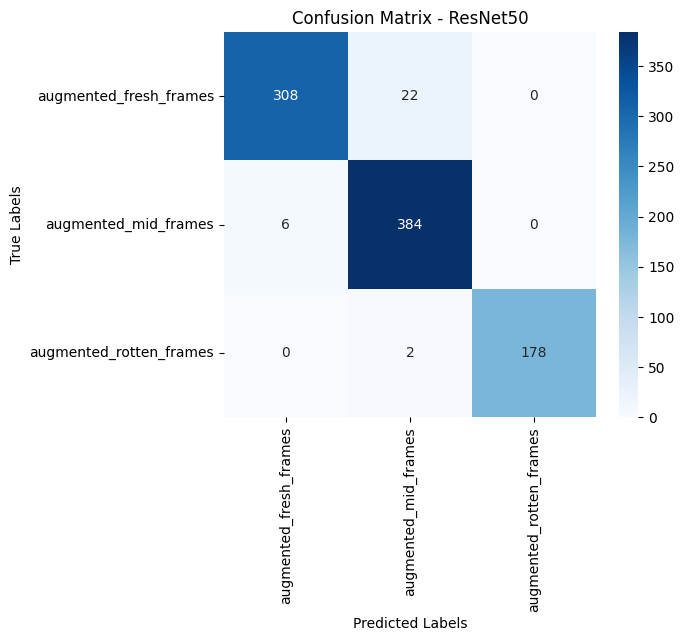

In [ ]:
#Confusion matrix
cm_resnet = confusion_matrix(y_true_resnet, y_pred_resnet)

plt.figure(figsize=(6, 5))
sns.heatmap(cm_resnet, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - ResNet50")
plt.show()

## Ensemble Model

In [ ]:
from tensorflow.keras.models import load_model

#Models for ensemble
model_mobilenet = load_model('best_model_mobilenet.h5')
model_efficientnet = load_model('best_model_efficientnet.h5')
model_densenet = load_model('best_model_densenet.h5')
model_resnet101 = load_model('best_model_resnet101.h5')

In [ ]:
model_nasnet = load_model('best_model_nasnet.h5')
model_resnet = load_model('best_model_resnet.h5')
model_vgg = load_model('best_vgg_model.h5')
model_xception = load_model('best_model_xception.h5')
model_inception = load_model('best_model_inception.h5')

In [ ]:
# Pred results from each model
pred_mobilenet = model_mobilenet.predict(val_data_mobilenet, verbose=1)
pred_efficientnet = model_efficientnet.predict(val_data_efficientnet, verbose=1)
pred_densenet = model_densenet.predict(val_data_preprocessed, verbose=1)
pred_resnet = model_resnet.predict(val_data_resnet, verbose=1)
pred_nasnet = model_nasnet.predict(val_data_nasnet, verbose=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 6s 206ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 446ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 56s 1s/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 13s 352ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 36s 743ms/step


In [ ]:
pred_resnet101 = model_resnet101.predict(val_data_resnet, verbose=1)
pred_vgg = model_vgg.predict(val_data_vgg, verbose=1)
pred_xception = model_xception.predict(val_data_xception, verbose=1)
pred_inception = model_inception.predict(val_data_inception, verbose=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 457ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 367ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 21s 365ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 23s 470ms/step


In [ ]:
true_labels = val_data.classes

#### Soft Voting (Average)

In [ ]:
from itertools import combinations, product
from sklearn.metrics import accuracy_score, f1_score, classification_report
import numpy as np

#Model predictions
models_pred = {
    'NASNet': pred_nasnet,
    'DenseNet201': pred_densenet,
    'ResNet50': pred_resnet,
    'ResNet101': pred_resnet101,
    'MobileNetV2': pred_mobilenet,
    'EfficientNetB0': pred_efficientnet,
    'VGG16': pred_vgg,
    'Xception': pred_xception,
    'InceptionV3': pred_inception,
}

metrics_info = {
    "accuracy": 0,
    "models": None,
    "weights": None
}

#Different model combinations
for combo in combinations(models_pred.keys(), 3):
    pred_list = [models_pred[m] for m in combo]
    steps = np.arange(0, 1.01, 0.01)

    for weights in product(steps, repeat=3):
        if np.isclose(sum(weights), 1.0):
            combined = sum(w * p for w, p in zip(weights, pred_list))
            preds = np.argmax(combined, axis=1)
            acc = accuracy_score(true_labels, preds)

            if acc > metrics_info["accuracy"]:
                metrics_info["accuracy"] = acc
                metrics_info["models"] = combo
                metrics_info["weights"] = weights

# Final result
print("Best Accuracy from 3-model ensemble:", metrics_info['accuracy'])
print("Best Model Combo:", metrics_info['models'])
print("Best Weights:", metrics_info['weights'])

Best Accuracy from 3-model ensemble: 0.9733333333333334
Best Model Combo: ('NASNet', 'ResNet50', 'EfficientNetB0')
Best Weights: (np.float64(0.4), np.float64(0.29), np.float64(0.31))


In [ ]:
model_nasnet = load_model('best_model_nasnet.h5')
model_resnet = load_model('best_model_resnet.h5')
model_efficientnet = load_model('best_model_efficientnet.h5')

In [ ]:
pred_efficientnet = model_efficientnet.predict(val_data_efficientnet, verbose=1)
pred_resnet = model_resnet.predict(val_data_resnet, verbose=1)
pred_nasnet = model_nasnet.predict(val_data_nasnet, verbose=1)

29/29 ━━━━━━━━━━━━━━━━━━━━ 419s 15s/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 16s 360ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 36s 693ms/step


In [ ]:
print(pred_nasnet[0])
print(pred_resnet[0])
print(pred_efficientnet[0])

[9.9999964e-01 3.6064819e-07 3.0562848e-12]
[9.9999988e-01 8.1261305e-08 1.0987465e-14]
[1.0000000e+00 5.0313680e-08 2.4153048e-13]


In [ ]:
avg_pred_weighted = (0.4*pred_nasnet + 0.29*pred_resnet + 0.31*pred_efficientnet) / 3.0
ensemble_prediction_weighted = np.argmax(avg_pred_weighted, axis=1)

In [ ]:
print("Ensemble Accuracy using Soft voting:", accuracy_score(true_labels, ensemble_prediction_weighted))
print("Classification Report:", classification_report(true_labels, ensemble_prediction_weighted))
print("Confusion Matrix:", confusion_matrix(true_labels, ensemble_prediction_weighted))

Ensemble Accuracy using Soft voting: 0.9733333333333334
Classification Report:               precision    recall  f1-score   support

           0       0.97      0.96      0.96       330
           1       0.96      0.97      0.97       390
           2       1.00      1.00      1.00       180

    accuracy                           0.97       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.97      0.97      0.97       900

Confusion Matrix: [[316  14   0]
 [ 10 380   0]
 [  0   0 180]]


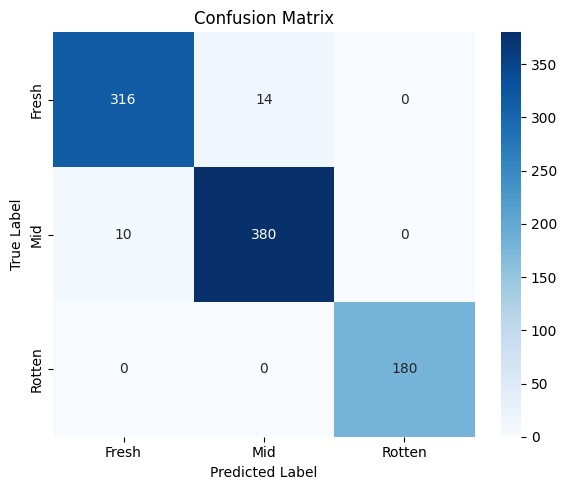

In [ ]:
#Confusion Matrix plot
cm_ensemble = confusion_matrix(true_labels, ensemble_prediction_weighted)

class_names = ['Fresh', 'Mid', 'Rotten']

plt.figure(figsize=(6, 5))
sns.heatmap(cm_ensemble, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [ ]:
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Input, Average, Dense, Lambda
import tensorflow as tf

# models for soft voting
nasnet = load_model('best_model_nasnet.h5')
resnet = load_model('best_model_resnet.h5')
efficientnet = load_model('best_model_efficientnet.h5')

nasnet.trainable = False
resnet.trainable = False
efficientnet.trainable = False

In [ ]:
input_shape = (224, 224, 3)
ensemble_input = Input(shape=input_shape)

#predictions
nasnet_output = nasnet(ensemble_input)
resnet_output = resnet(ensemble_input)
efficientnet_output = efficientnet(ensemble_input)

#soft voting with weights
weighted_output = Lambda(lambda x: (0.4 * x[0] + 0.29 * x[1] + 0.31 * x[2]))([nasnet_output, resnet_output, efficientnet_output])

final_output = tf.keras.layers.Softmax()(weighted_output)

# Build and save the model
ensemble_model = Model(inputs=ensemble_input, outputs=final_output)
ensemble_model.save('soft_voting_ensemble.keras')

#### Hard voting

In [ ]:
from scipy.stats import mode

stacked_pred = np.stack([
    np.argmax(pred_nasnet, axis=1),
    np.argmax(pred_efficientnet, axis=1),
    np.argmax(pred_resnet, axis=1)], axis=1)

hard_vote_pred, count = mode(stacked_pred, axis=1) #mode, count
final_preds = hard_vote_pred.flatten()

In [ ]:
print("Ensemble Accuracy using Hard Voting:", accuracy_score(true_labels, final_preds))
print("Classification Report:", classification_report(true_labels, final_preds))
print("Confusion Matrix:", confusion_matrix(true_labels, final_preds))

Ensemble Accuracy using Hard Voting: 0.9722222222222222
Classification Report:               precision    recall  f1-score   support

           0       0.97      0.96      0.96       330
           1       0.96      0.97      0.97       390
           2       1.00      0.99      1.00       180

    accuracy                           0.97       900
   macro avg       0.98      0.98      0.98       900
weighted avg       0.97      0.97      0.97       900

Confusion Matrix: [[316  14   0]
 [ 10 380   0]
 [  0   1 179]]


##  Feature-Level Model Ensemble

#### VGG16 + ResNet50 + MobileNetV2

In [ ]:
def rename_model(model, prefix, input_shape=(224, 224, 3)):
    # Freeze original model
    model.trainable = True

    # Create new input
    new_input = Input(shape=input_shape, name=f'{prefix}_input')

    # Apply model to the new input
    new_output = model(new_input)

    # Create a new model with renamed scope
    new_model = Model(inputs=new_input, outputs=new_output, name=f'{prefix}_model')

    return new_model

# Load and wrap each model
vgg = rename_model(load_model('best_vgg_model.h5', compile=False), 'vgg')
resnet = rename_model(load_model('best_model_resnet.h5', compile=False), 'resnet')
mobilenet = rename_model(load_model('best_model_mobilenet.h5', compile=False), 'mobilenet')

# common input
commonInput = Input((224, 224, 3), name="ensemble_input")
out1 = vgg(commonInput)
out2 = resnet(commonInput)
out3 = mobilenet(commonInput)

# Merged outputs
merged = Add(name='merge_outputs')([out1, out2, out3])

# ensemble model
newModel = Model(inputs=commonInput, outputs=merged, name='ensemble_model')

In [ ]:
# Compilation
newModel.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
newModel.summary()

Model: "ensemble_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ensemble_input      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg_model           │ (None, 3)         │ 14,846,787 │ ensemble_input[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet_model        │ (None, 3)         │ 24,113,027 │ ensemble_input[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenet_model     │ (None, 3)         │  2,586,691 │ ensemble_input[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge_outputs (Add) │ (None, 3)         │          0 │ vgg_model[0][0],  │
│                     │                   │            │ resnet_model[0][… │
│                     │                   │            │ mobilenet_model[… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 41,546,505 (158.49 MB)

 Trainable params: 986,121 (3.76 MB)

 Non-trainable params: 40,560,384 (154.73 MB)

In [ ]:
checkpoint_ensemble = ModelCheckpoint(
    'model_ensemble.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

start_ensemble = time.time()

history_ensemble = newModel.fit(
    train_data_mobilenet,
    epochs=50,
    validation_data=val_data_mobilenet,
    callbacks=[checkpoint_ensemble]
)

end_ensemble = time.time()
runtime_ensemble = end_ensemble - start_ensemble

print(f"Training Time for Ensemble model: {runtime_ensemble:.2f} seconds")

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 498ms/step - accuracy: 0.8157 - loss: 0.5316
Epoch 1: val_accuracy improved from -inf to 0.90667, saving model to model_ensemble.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 79s 884ms/step - accuracy: 0.8164 - loss: 0.5308 - val_accuracy: 0.9067 - val_loss: 0.3738
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.9162 - loss: 0.3499
Epoch 2: val_accuracy improved from 0.90667 to 0.92556, saving model to model_ensemble.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 43s 429ms/step - accuracy: 0.9163 - loss: 0.3496 - val_accuracy: 0.9256 - val_loss: 0.2884
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.9226 - loss: 0.2801
Epoch 3: val_accuracy did not improve from 0.92556
66/66 ━━━━━━━━━━━━━━━━━━━━ 27s 397ms/step - accuracy: 0.9227 - loss: 0.2800 - val_accuracy: 0.9222 - val_loss: 0.2701
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.9275 - loss: 0.2639
Epoch 4: val_accuracy improved from 0.92556 to 0.93222, saving model

In [ ]:
ensemble_concatenate = load_model('model_ensemble.keras')

In [ ]:
loss_ensemble, accuracy_ensemble = ensemble_concatenate.evaluate(val_data_mobilenet)
print(f"Validation Accuracy: {accuracy_ensemble:.4f}, Validation Loss: {loss_ensemble:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 20s 378ms/step - accuracy: 0.9509 - loss: 0.1613
Validation Accuracy: 0.9644, Validation Loss: 0.1670


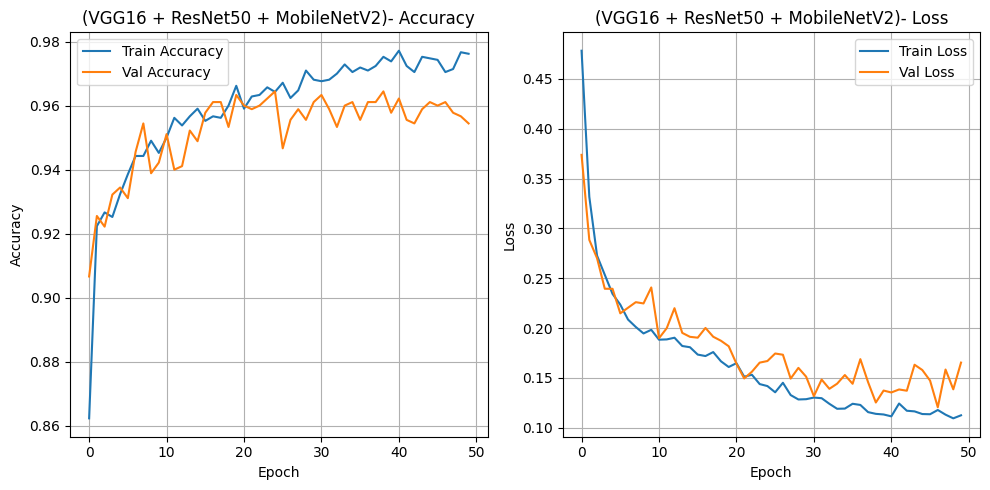

In [ ]:
#Plots for Ensemble model Accuracy and loss
plt.figure(figsize=(10, 5))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_ensemble.history['accuracy'], label='Train Accuracy')
plt.plot(history_ensemble.history['val_accuracy'], label='Val Accuracy')
plt.title('(VGG16 + ResNet50 + MobileNetV2)- Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

#Loss
plt.subplot(1, 2, 2)
plt.plot(history_ensemble.history['loss'], label='Train Loss')
plt.plot(history_ensemble.history['val_loss'], label='Val Loss')
plt.title('(VGG16 + ResNet50 + MobileNetV2)- Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Confusion matrix
#Prediction on validation data
val_pred_ensemble = ensemble_concatenate.predict(val_data_mobilenet)
y_pred_ensemble = np.argmax(val_pred_ensemble , axis=1)

y_true_ensemble  = val_data_mobilenet.classes

class_names = list(val_data_mobilenet.class_indices.keys())

29/29 ━━━━━━━━━━━━━━━━━━━━ 22s 512ms/step


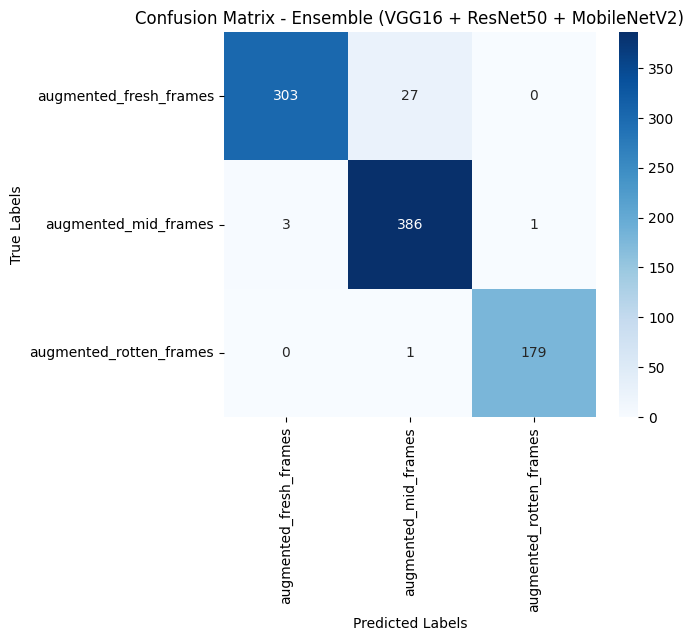

In [ ]:
cm_ensemble = confusion_matrix(y_true_ensemble , y_pred_ensemble)
#show cm
plt.figure(figsize=(6, 5))
sns.heatmap(cm_ensemble, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Ensemble (VGG16 + ResNet50 + MobileNetV2)')
plt.show()

#### NASNetMobile + ResNet50 + EfficientNetB0

In [ ]:
def rename_model(model, prefix, input_shape=(224, 224, 3)):
    # Freeze original model
    model.trainable = True

    # Create new input
    new_input = Input(shape=input_shape, name=f'{prefix}_input')

    # Apply model to the new input
    new_output = model(new_input)

    # Create a new model with renamed scope
    new_model = Model(inputs=new_input, outputs=new_output, name=f'{prefix}_model')

    return new_model

In [ ]:
# Load and wrap each model
efficientnet = rename_model(load_model('best_model_efficientnet.h5', compile=False), 'efficientnet')
resnet = rename_model(load_model('best_model_resnet.h5', compile=False), 'resnet')
nasnet = rename_model(load_model('best_model_nasnet.h5', compile=False), 'nasnet')

# common input
commonInput = Input((224, 224, 3), name="ensemble_input")
out1 = efficientnet(commonInput)
out2 = resnet(commonInput)
out3 = nasnet(commonInput)

# Merged outputs
merged = Add(name='merge_outputs')([out1, out2, out3])

# ensemble model
newModel2 = Model(inputs=commonInput, outputs=merged, name='ensemble_model')

In [ ]:
# Compilation
newModel2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Summary
newModel2.summary()

Model: "ensemble_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ ensemble_input      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnet_model  │ (None, 3)         │  4,378,278 │ ensemble_input[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet_model        │ (None, 3)         │ 24,113,027 │ ensemble_input[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ nasnet_model        │ (None, 3)         │  4,541,079 │ ensemble_input[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ merge_outputs (Add) │ (None, 3)         │          0 │ efficientnet_mod… │
│                     │                   │            │ resnet_model[0][… │
│                     │                   │            │ nasnet_model[0][… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 33,032,384 (126.01 MB)

 Trainable params: 1,125,385 (4.29 MB)

 Non-trainable params: 31,906,999 (121.72 MB)

In [ ]:
checkpoint_ensemble2 = ModelCheckpoint(
    'model_ensemble2.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

start_ensemble2 = time.time()

history_ensemble2 = newModel2.fit(
    train_data_efficientnet,
    epochs=50,
    validation_data=val_data_efficientnet,
    callbacks=[checkpoint_ensemble2]
)

end_ensemble2 = time.time()
runtime_ensemble2 = end_ensemble2 - start_ensemble2

print(f"Training Time for Ensemble model 2: {runtime_ensemble2:.2f} seconds")

Epoch 1/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 706ms/step - accuracy: 0.9282 - loss: 0.4557
Epoch 1: val_accuracy improved from -inf to 0.96000, saving model to model_ensemble2.keras
66/66 ━━━━━━━━━━━━━━━━━━━━ 178s 2s/step - accuracy: 0.9284 - loss: 0.4553 - val_accuracy: 0.9600 - val_loss: 0.4000
Epoch 2/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.9629 - loss: 0.3988
Epoch 2: val_accuracy did not improve from 0.96000
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 467ms/step - accuracy: 0.9629 - loss: 0.3988 - val_accuracy: 0.9589 - val_loss: 0.3954
Epoch 3/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 310ms/step - accuracy: 0.9583 - loss: 0.4006
Epoch 3: val_accuracy did not improve from 0.96000
66/66 ━━━━━━━━━━━━━━━━━━━━ 31s 468ms/step - accuracy: 0.9583 - loss: 0.4007 - val_accuracy: 0.9500 - val_loss: 0.4067
Epoch 4/50
66/66 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.9513 - loss: 0.3996
Epoch 4: val_accuracy did not improve from 0.96000
66/66 ━━━━━━━━━━━━━━━━━━━━ 26s 390ms/step - accuracy: 0.9513

In [ ]:
ensemble_model2 = load_model('model_ensemble2.keras')

In [ ]:
loss_ensemble2, accuracy_ensemble2 = ensemble_model2.evaluate(val_data_efficientnet)
print(f"Validation Accuracy: {accuracy_ensemble2:.4f}, Validation Loss: {loss_ensemble2:.4f}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 49s 691ms/step - accuracy: 0.9444 - loss: 0.5979
Validation Accuracy: 0.9600, Validation Loss: 0.4783


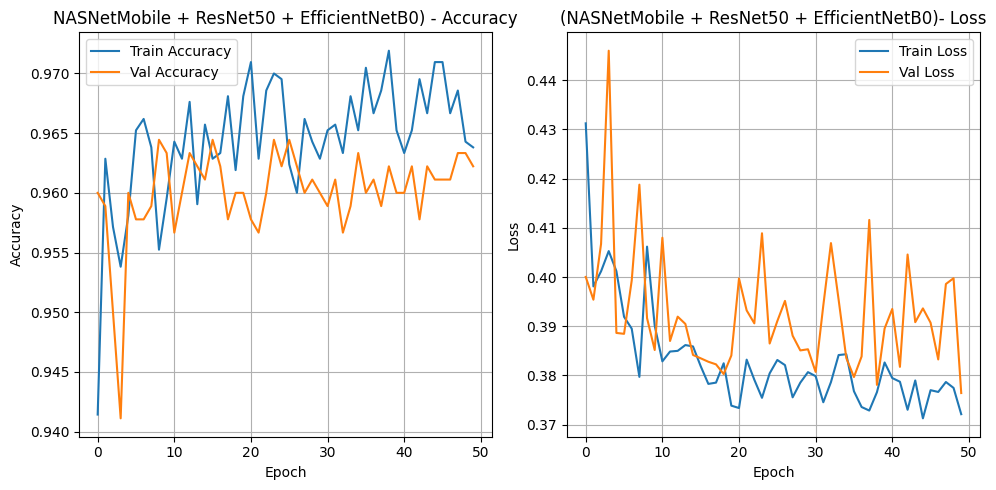

In [ ]:
#Plots for Ensemble model 2 Accuracy and loss
plt.figure(figsize=(10, 5))

#Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_ensemble2.history['accuracy'], label='Train Accuracy')
plt.plot(history_ensemble2.history['val_accuracy'], label='Val Accuracy')
plt.title('NASNetMobile + ResNet50 + EfficientNetB0) - Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

#Loss
plt.subplot(1, 2, 2)
plt.plot(history_ensemble2.history['loss'], label='Train Loss')
plt.plot(history_ensemble2.history['val_loss'], label='Val Loss')
plt.title('(NASNetMobile + ResNet50 + EfficientNetB0)- Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
#Confusion matrix
#Prediction on validation data
val_pred_ensemble2 = ensemble_model2.predict(val_data_efficientnet)
y_pred_ensemble2 = np.argmax(val_pred_ensemble2, axis=1)

y_true_ensemble2  = val_data_efficientnet.classes

class_names = list(val_data_efficientnet.class_indices.keys())

29/29 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step


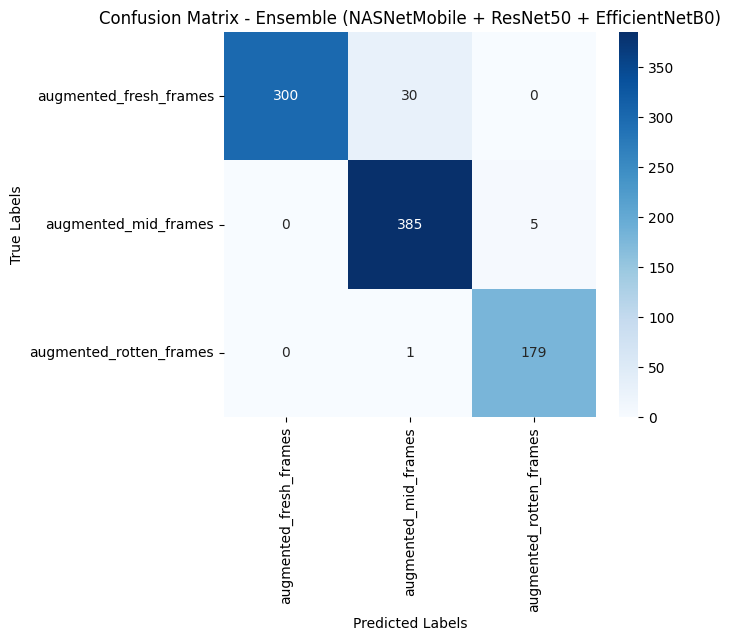

In [ ]:
cm_ensemble2 = confusion_matrix(y_true_ensemble2 , y_pred_ensemble2)
#show cm
plt.figure(figsize=(6, 5))
sns.heatmap(cm_ensemble2, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Ensemble (NASNetMobile + ResNet50 + EfficientNetB0)')
plt.show()